In [1]:
%%html
<style>.container { width:95% !important; }</style>

# Media Mix Modeling Data Generator

This document provides a detailed explanation of the synthetic data generator for Media Mix Modeling (MMM). The generator creates a realistic dataset that simulates how various advertising channels affect sales, incorporating effects like adstock (carryover), saturation (diminishing returns), and external factors.

## 1. Model Structure and Implementation

### 1.1 Time Component
The generator creates monthly data over a 5-year period (2017-2021), providing 60 data points for analysis. Each data point includes:
- Year and month identifiers
- Time period in a readable format (e.g., "Jan 2021")

### 1.2 Media Spend Generation
Media spend is simulated using a combination of:

- **Base spend levels**: Initial values for each channel
- **Seasonal patterns**: Channel-specific seasonality
- **Growth trends**: Different growth trajectories for each channel
- **Random variation**: Controlled volatility to create realistic fluctuations
- **Experimental periods**: Simulated campaign tests with moderate spend increases

The implementation uses the following approach:
```python
# Base spend parameters
base_spend = {
    'TV': 20000,
    'Digital': 15000,
    'Radio': 5000,
    'Print': 3000
}

# Annual growth rates (different for each channel)
growth_rates = {
    'TV': 1.05,       # 5% annual growth
    'Digital': 1.15,  # 15% annual growth (digital grows faster)
    'Radio': 1.02,    # 2% annual growth
    'Print': 0.98     # 2% annual decline (print declining)
}
```

Additionally, the generator creates experiment-like patterns where individual channels experience spend spikes in specific periods:
```python
# Define experiment periods
experiments = {
    'TV': {'year': 2018, 'months': [3, 4]},
    'Digital': {'year': 2019, 'months': [7, 8]},
    'Radio': {'year': 2020, 'months': [1, 2]},
    'Print': {'year': 2020, 'months': [9, 10]}
}

# Increase spend during experiment periods (by 50%)
for channel, period in experiments.items():
    exp_indices = [i for i, date in enumerate(date_range) 
                  if date.year == period['year'] and date.month in period['months']]
    
    for idx in exp_indices:
        df.loc[idx, f'{channel}_Spend'] *= 1.5
```

These experimental patterns help improve parameter identifiability when analyzing the data by creating realistic variations in spending levels.

### 1.3 Adstock Transformation
Advertising effects often carry over into future periods. The adstock transformation captures this with:

**Formula**: S_t = X_t + λ*S_{t-1}

Where:
- S_t is the adstocked value at time t
- X_t is the raw media spend at time t
- λ is the decay factor (between 0 and 1)

Different decay rates are applied to each channel:
```python
decay_rates = {
    'TV': 0.8,       # TV has longer-lasting effects
    'Digital': 0.3,  # Digital has short-lived effects
    'Radio': 0.5,    # Radio has medium carryover
    'Print': 0.7     # Print has medium-high carryover
}
```

The distinct decay rates help in parameter identification during analysis.

### 1.4 Hill Saturation Function
Advertising typically shows diminishing returns as spend increases. The Hill function models this saturation effect:

**Formula**: Impact = α × (S^γ) / (S^γ + K^γ)

Where:
- S is the adstocked media value
- α is the maximum potential impact
- K is the half-saturation point (spend where 50% of maximum effect is achieved)
- γ is the steepness parameter (how quickly diminishing returns set in)

Parameters are channel-specific:
```python
hill_params = {
    'TV': {'alpha': 25000, 'gamma': 0.7, 'k': 35000},      # TV has high impact but high saturation
    'Digital': {'alpha': 20000, 'gamma': 0.6, 'k': 25000}, # Digital has good efficiency
    'Radio': {'alpha': 12000, 'gamma': 0.8, 'k': 12000},   # Radio has moderate impact
    'Print': {'alpha': 8000, 'gamma': 0.9, 'k': 10000}     # Print has lower impact
}
```

### 1.5 External Factors

#### Economic Conditions
The generator simulates economic conditions using a Markov chain model with three states:
- Stable (majority of time)
- Growth (moderate occurrence)
- Declining (less frequent)

Economic conditions affect sales with these multipliers:
```python
economic_value = {
    'Declining': 0.95,  # 5% decrease in baseline sales
    'Stable': 1.0,      # No change to baseline
    'Growth': 1.05      # 5% increase in baseline sales
}
```

#### Seasonal Events
Major seasonal events are included with varying impacts on sales:
```python
seasonal_multipliers = {
    'None': 1.0,
    'New Year': 0.98,
    'Valentine\'s Day': 1.02,
    'Easter': 1.04,
    'Memorial Day': 1.05,
    'Independence Day': 1.03,
    'Labor Day': 1.02,
    'Halloween': 1.07,
    'Thanksgiving': 1.06,
    'Black Friday': 1.15,
    'Christmas': 1.20
}
```


### 1.7 Sales Generation
The final sales value for each period is calculated as:

**Formula**: Sales = (Base_Sales × Season_Factor × Economic_Index) + Total_Media_Impact + Experiment_Boost + Noise

Where:
- Base_Sales follows a growth trend of 0.5% per month
- Season_Factor depends on the seasonal event for that period
- Economic_Index depends on the economic condition
- Total_Media_Impact is the sum of all channel impacts after adstock and hill transformations
- Experiment_Boost is calculated using the improved approach detailed above
- Noise is a random factor with 3% standard deviation

## 2. Output Data

The generated dataset includes the following columns:

### 2.1 Core Data Columns
- **Time_Period**: Month and year (e.g., "Jan 2017")
- **TV_Spend, Digital_Spend, Radio_Spend, Print_Spend**: Media spend by channel
- **Total_Sales**: Generated sales figures
- **Economic_Condition**: Current economic state
- **Seasonal_Event**: Holiday or event occurring in that period

### 2.2 Experiment Indicators
- **Is_Experiment**: Binary flag indicating if this period was part of an experiment (1=yes, 0=no)
- **Experiment_Channel**: The channel being tested during experiment periods

### 2.3 Model Parameters (Ground Truth)
- **TV_Decay, Digital_Decay, Radio_Decay, Print_Decay**: The adstock decay parameters
- **TV_alpha, Digital_alpha, Radio_alpha, Print_alpha**: Maximum impact parameters
- **TV_gamma, Digital_gamma, Radio_gamma, Print_gamma**: Hill function steepness parameters
- **TV_k, Digital_k, Radio_k, Print_k**: Half-saturation point parameters


### 4.2 Data Generation Example

To generate a dataset with the improved experiment effects:

```python
# Generate data with 70% experiment realism (the default value)
mmm_data = generate_mmm_data(experiment_realism=0.7)

```

### 4.3 Known Patterns

Some patterns in the data are deliberate and reflect real-world marketing phenomena:
- Print shows a slightly negative relationship with sales, representing declining effectiveness of traditional channels
- TV has high impact but also high saturation (diminishing returns)
- Digital shows strong growth and relatively good efficiency
- Seasonal events create significant variability in the underlying baseline

# Data generating function

In [123]:
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', 1000)
pd.set_option('display.max_colwidth', None)
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import random

# Set random seed for reproducibility
#np.random.seed(42)
#random.seed(42)

def generate_mmm_data(start_date='2017-01-01', end_date='2021-12-31', experiment_realism=0.7):
    """
    Generate synthetic Media Mix Modeling data with realistic properties.
    
    Args:
        start_date (str): Start date in YYYY-MM-DD format
        end_date (str): End date in YYYY-MM-DD format
        experiment_realism (float): Factor between 0-1 controlling how much of the expected
                                   linear impact experiments should have (default: 0.7)
        
    Returns:
        pandas.DataFrame: Generated MMM dataset
    """
    # Step 1: Define the time horizon
    date_range = pd.date_range(start=start_date, end=end_date, freq='MS')
    n_periods = len(date_range)
    
    # Create dataframe with time components
    df = pd.DataFrame({
        'Date': date_range,
        'Year': date_range.year,
        'Month': date_range.month,
        'Time_Period': [f"{date.strftime('%b')} {date.year}" for date in date_range]
    })
    
    # Step 2: Generate media spend data with trends and seasonality
    # Define seasonality patterns for each channel
    def seasonal_factor(month, channel):
        if channel == 'TV':
            # TV has higher spend in Q4 (10-12) and lower in summer (6-8)
            if month in [10, 11, 12]:
                return 1.3
            elif month in [6, 7, 8]:
                return 0.8
            else:
                return 1.0
        elif channel == 'Digital':
            # Digital relatively stable with slight increase in Q4
            if month in [11, 12]:
                return 1.2
            else:
                return 1.0
        elif channel == 'Radio':
            # Radio higher in summer months
            if month in [5, 6, 7, 8]:
                return 1.2
            else:
                return 0.9
        elif channel == 'Print':
            # Print higher around holidays
            if month in [11, 12, 1, 2]:
                return 1.1
            else:
                return 0.9
    
    # Base spend parameters
    base_spend = {
        'TV': 20000,
        'Digital': 15000,
        'Radio': 5000,
        'Print': 3000
    }
    
    # Generate spend with random walk + seasonality + trend
    for channel in ['TV', 'Digital', 'Radio', 'Print']:
        # Initialize with base spend
        spend = [base_spend[channel]]
        
        # Annual growth rate (different for each channel)
        growth_rates = {
            'TV': 1.05,  # 5% annual growth
            'Digital': 1.15,  # 15% annual growth (digital grows faster)
            'Radio': 1.02,  # 2% annual growth
            'Print': 0.98   # 2% annual decline (print declining)
        }
        
        # Generate spend for each period with random walk + seasonality + trend
        for i in range(1, n_periods):
            month = df.loc[i, 'Month']
            year_diff = df.loc[i, 'Year'] - df.loc[0, 'Year']
            
            # Calculate trend factor based on years passed
            trend_factor = growth_rates[channel] ** year_diff
            
            # Get seasonal factor
            season = seasonal_factor(month, channel)
            
            # Random walk component (with bounded volatility)
            volatility = 0.08  # 8% volatility
            random_factor = 1 + np.random.normal(0, volatility)
            random_factor = max(0.9, min(1.1, random_factor))  # Limit extreme values
            
            # Calculate next spend value with smoothing
            prev_spend = spend[-1]
            next_spend = prev_spend * 0.85 + base_spend[channel] * trend_factor * season * random_factor * 0.15
            
            # Ensure no negative spend
            next_spend = max(next_spend, base_spend[channel] * 0.6)
            
            spend.append(round(next_spend))
        
        # Add to dataframe
        df[f'{channel}_Spend'] = spend
        
    # Define experiment periods
    experiments = {
        'TV': {'year': 2018, 'months': [3, 4]},
        'Digital': {'year': 2019, 'months': [7, 8]},
        'Radio': {'year': 2020, 'months': [1, 2]},
        'Print': {'year': 2020, 'months': [9, 10]}
    }

    # Store original spend before applying experiments (to calculate relative increase)
    for channel in ['TV', 'Digital', 'Radio', 'Print']:
        df[f'{channel}_Original_Spend'] = df[f'{channel}_Spend'].copy()

    # Apply experiments to increase spend
    for channel, period in experiments.items():
        # Find indices for experiment periods
        exp_indices = [i for i, date in enumerate(date_range) 
                      if date.year == period['year'] and date.month in period['months']]
        
        for idx in exp_indices:
            # Apply a moderate multiplier (1.5x)
            df.loc[idx, f'{channel}_Spend'] *= 1.5

    # Step 3: Apply Adstock Transformation
    # Define decay parameters for each channel
    decay_rates = {
        'TV': 0.8,       # TV has longer-lasting effects
        'Digital': 0.3,  # Digital has very short-lived effects
        'Radio': 0.5,    # Radio has medium carryover
        'Print': 0.7     # Print has medium-high carryover
    }
        
    # Apply adstock transformation
    for channel in ['TV', 'Digital', 'Radio', 'Print']:
        spend_col = f'{channel}_Spend'
        adstock_col = f'{channel}_Adstocked'
        
        # Initialize adstock with first period spend
        adstock = [df.loc[0, spend_col]]
        
        # Calculate adstock for remaining periods
        for i in range(1, n_periods):
            current_spend = df.loc[i, spend_col]
            prev_adstock = adstock[-1]
            
            # Adstock formula: S_t = X_t + λ*S_{t-1}
            new_adstock = current_spend + decay_rates[channel] * prev_adstock
            adstock.append(new_adstock)
        
        # Add to dataframe
        df[adstock_col] = adstock
    
    # Step 4: Apply Hill Saturation Function (for diminishing returns)
    # Define parameters for Hill function for each channel
    hill_params = {
        'TV': {'alpha': 25000, 'gamma': 0.7, 'k': 35000},       # TV has high impact but high saturation
        'Digital': {'alpha': 20000, 'gamma': 0.6, 'k': 25000},  # Digital has good efficiency
        'Radio': {'alpha': 12000, 'gamma': 0.8, 'k': 12000},    # Radio has moderate impact
        'Print': {'alpha': 8000, 'gamma': 0.9, 'k': 10000}      # Print has lower impact
    }
    
    # Calculate media impact with Hill function
    for channel in ['TV', 'Digital', 'Radio', 'Print']:
        adstock_col = f'{channel}_Adstocked'
        impact_col = f'{channel}_Impact'
        
        alpha = hill_params[channel]['alpha']
        gamma = hill_params[channel]['gamma']
        k = hill_params[channel]['k']
        
        # Calculate media impact using Hill function
        adstocked_values = df[adstock_col].values
        numerator = adstocked_values ** gamma
        denominator = adstocked_values ** gamma + k ** gamma
        impact = alpha * (numerator / denominator)
        
        # Add to dataframe
        df[impact_col] = impact
    
    # Step 5: Generate External Factors & Seasonality
    
    # Economic condition (random walk with persistence)
    economic_conditions = ['Stable', 'Growth', 'Declining']
    weights = [0.6, 0.25, 0.15]  # More stability, some growth, less decline
    
    # Initialize with random condition
    econ_condition = [np.random.choice(economic_conditions, p=weights)]
    
    # Generate conditions with Markov-like transitions (persistence)
    transition_matrix = {
        'Stable': {'Stable': 0.8, 'Growth': 0.15, 'Declining': 0.05},
        'Growth': {'Stable': 0.2, 'Growth': 0.75, 'Declining': 0.05},
        'Declining': {'Stable': 0.3, 'Growth': 0.1, 'Declining': 0.6}
    }
    
    for i in range(1, n_periods):
        prev_condition = econ_condition[-1]
        probs = list(transition_matrix[prev_condition].values())
        next_condition = np.random.choice(
            economic_conditions, 
            p=probs
        )
        econ_condition.append(next_condition)
    
    df['Economic_Condition'] = econ_condition
    
    # Economic index (numerical value corresponding to condition)
    economic_value = {
        'Declining': 0.95,
        'Stable': 1.0,
        'Growth': 1.05
    }
    df['Economic_Index'] = [economic_value[cond] for cond in df['Economic_Condition']]
    
    # Seasonal Events
    # Define holidays and special events
    seasonal_events = {
        (1, 1): 'New Year',
        (2, 14): 'Valentine\'s Day',
        # Easter varies, will be added separately
        (5, 31): 'Memorial Day',  # Approximate
        (7, 4): 'Independence Day',
        (9, 1): 'Labor Day',  # Approximate
        (10, 31): 'Halloween',
        (11, 25): 'Thanksgiving',  # Approximate
        (11, 26): 'Black Friday',  # Approximate
        (12, 25): 'Christmas'
    }
    
    # Add Easter (approximated for simplicity)
    easter_dates = {
        2017: (4, 16),
        2018: (4, 1),
        2019: (4, 21), 
        2020: (4, 12),
        2021: (4, 4)
    }
    
    # Initialize with 'None'
    df['Seasonal_Event'] = 'None'
    
    # Fill in seasonal events
    for i, row in df.iterrows():
        year = row['Year']
        month = row['Month']
        
        # Check for fixed holidays
        for (m, d), event in seasonal_events.items():
            if month == m:
                df.at[i, 'Seasonal_Event'] = event
                break
        
        # Check for Easter
        if year in easter_dates and month == easter_dates[year][0]:
            df.at[i, 'Seasonal_Event'] = 'Easter'
    
    # Step 6: Compute Final Sales
    
    # Base sales (with growth trend)
    base_sales = 80000  # Starting base sales
    growth_trend = 1.005  # Monthly growth rate (0.5% per month)
    base_sales_values = [base_sales * (growth_trend ** i) for i in range(n_periods)]
    
    # Add seasonal factors to base sales
    seasonal_multipliers = {
        'None': 1.0,
        'New Year': 0.98,
        'Valentine\'s Day': 1.02,
        'Easter': 1.04,
        'Memorial Day': 1.05,
        'Independence Day': 1.03,
        'Labor Day': 1.02,
        'Halloween': 1.07,
        'Thanksgiving': 1.06,
        'Black Friday': 1.15,
        'Christmas': 1.20
    }
    
    # Economic impact on sales
    economic_impact = df['Economic_Index'].values
    
    # Calculate total media impact
    total_media_impact = (
        df['TV_Impact'] + 
        df['Digital_Impact'] + 
        df['Radio_Impact'] + 
        df['Print_Impact']
    ).values
    
    experiment_boost = np.zeros(n_periods)

    # These are higher than regular marginal rates to reflect focus and optimization during test periods
    experiment_response_rates = {
        'TV': 2.8,       # Higher response during focused TV experiments
        'Digital': 3.5,  # Digital often performs very well during targeted experiments
        'Radio': 2.2,    # Radio experiments show moderate lift
        'Print': 1.8     # Print shows some lift during experiments
    }

    # Calculate experiment boosts based on both spend increase and improved effectiveness
    for channel, period in experiments.items():
        # Find indices for experiment periods
        exp_indices = [i for i, date in enumerate(date_range) 
                      if date.year == period['year'] and date.month in period['months']]

        for idx in exp_indices:
            # Calculate the spend increase during experiment
            original_spend = df.loc[idx, f'{channel}_Original_Spend']
            experiment_spend = df.loc[idx, f'{channel}_Spend']
            spend_increase = experiment_spend - original_spend

            # Get the enhanced response rate for this experiment
            exp_response = experiment_response_rates[channel]

            # Calculate expected impact with higher experiment effectiveness
            # This reflects both higher spend AND better performance during experiments
            experiment_impact = spend_increase * exp_response

            # Add base impact boost to reflect improved targeting/creative during experiments
            base_boost = original_spend * 0.05  # 5% lift on base spend from optimization

            # Add to the experiment boost
            experiment_boost[idx] += (experiment_impact + base_boost)

    # Mark experiment periods in the dataframe
    df['Is_Experiment'] = 0
    df['Experiment_Channel'] = ''
    for channel, period in experiments.items():
        exp_mask = (df['Year'] == period['year']) & (df['Month'].isin(period['months']))
        df.loc[exp_mask, 'Is_Experiment'] = 1
        df.loc[exp_mask, 'Experiment_Channel'] = channel
    
    # Calculate total sales with all factors
    sales = []
    for i in range(n_periods):
        event = df.loc[i, 'Seasonal_Event']
        season_factor = seasonal_multipliers.get(event, 1.0)
        
        # Combine all factors with some interaction effects
        sales_value = (
            base_sales_values[i] * 
            season_factor * 
            economic_impact[i] + 
            total_media_impact[i]
        )
        
        # Add experiment boost with the new approach
        sales_value += experiment_boost[i]
        
        # Add some noise (3% random variation)
        noise = np.random.normal(1, 0.03)
        sales_value *= noise
        
        # Round to clean number
        sales.append(round(sales_value, -3))  # Round to thousands
    
    df['Total_Sales'] = sales
    
    # Optional: Add columns to help diagnose experiment periods
    df['Is_Experiment'] = 0
    df['Experiment_Channel'] = ''
    for channel, period in experiments.items():
        exp_indices = [i for i, date in enumerate(date_range) 
                      if date.year == period['year'] and date.month in period['months']]
        for idx in exp_indices:
            df.loc[idx, 'Is_Experiment'] = 1
            df.loc[idx, 'Experiment_Channel'] = channel
    
    # Add model parameters to dataset
    df['TV_Decay'] = decay_rates['TV']
    df['Digital_Decay'] = decay_rates['Digital']
    df['Radio_Decay'] = decay_rates['Radio'] 
    df['Print_Decay'] = decay_rates['Print']

    for channel in ['TV', 'Digital', 'Radio', 'Print']:
        for param in ['alpha', 'gamma', 'k']:
            df[f'{channel}_{param}'] = hill_params[channel][param]

    return df

# Example usage
# mmm_data = generate_mmm_data()

# Generate a dataset

In [140]:
# Set random seed for reproducibility 
np.random.seed(369)

data = generate_mmm_data()
data_file="MMM_data.csv"
data.to_csv(data_file, index=False)

# Checking the outcome of the data generating process

NOTE, THIS IS NOT THE ANALYSIS REPORT. THIS IS PURELY A QUICK CHECK IF THE GENERATED DATA IS REASONABLE. 

In [141]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import StrMethodFormatter


def check_data(data_file=data_file, save_plots_to_disk = False):


    # Set plot styling
    plt.style.use('ggplot')
    sns.set_palette("deep")

    # Load data
    print(f"Loading data from {data_file}...")
    mmm_data = pd.read_csv(data_file)

    # Display the first few rows
    print("First 5 rows of the generated data:")
    display(mmm_data.head())

    # Create a DataFrame with column names and descriptions
    column_descriptions = pd.DataFrame({
        'Column Name': [
            'Time_Period', 'TV_Spend', 'Digital_Spend', 'Radio_Spend', 'Print_Spend', 
            'Total_Sales', 'Economic_Condition', 'Seasonal_Event', 'Is_Experiment', 'Experiment_Channel',
            'TV_Decay', 'Digital_Decay', 'Radio_Decay', 'Print_Decay',
            'TV_alpha', 'TV_gamma', 'TV_k', 
            'Digital_alpha', 'Digital_gamma', 'Digital_k',
            'Radio_alpha', 'Radio_gamma', 'Radio_k',
            'Print_alpha', 'Print_gamma', 'Print_k',
            'TV_Adstocked', 'Digital_Adstocked', 'Radio_Adstocked', 'Print_Adstocked',
            'TV_Impact', 'Digital_Impact', 'Radio_Impact', 'Print_Impact'
        ],
        'Description': [
            'Time period (month and year) for the data point',
            'Amount spent on television advertising during the period ($)',
            'Amount spent on digital advertising during the period ($)',
            'Amount spent on radio advertising during the period ($)', 
            'Amount spent on print advertising during the period ($)',
            'Total sales revenue recorded during the period ($)',
            'Macroeconomic condition during the period (Declining, Stable, or Growth)',
            'Special seasonal event occurring during the period (e.g., Black Friday, Christmas, None)',
            'Flag indicating if this period was part of an experiment (1=yes, 0=no)',
            'The channel being tested during experiment periods',
            'Decay rate (λ) for TV advertising effect, controlling how quickly the impact diminishes',
            'Decay rate (λ) for Digital advertising effect, controlling how quickly the impact diminishes',
            'Decay rate (λ) for Radio advertising effect, controlling how quickly the impact diminishes',
            'Decay rate (λ) for Print advertising effect, controlling how quickly the impact diminishes',
            'Maximum potential impact parameter (α) for TV in the Hill function',
            'Steepness parameter (γ) for TV in the Hill function, controls response curve shape',
            'Half-saturation parameter (k) for TV in the Hill function, spend at which impact is half of maximum',
            'Maximum potential impact parameter (α) for Digital in the Hill function',
            'Steepness parameter (γ) for Digital in the Hill function, controls response curve shape',
            'Half-saturation parameter (k) for Digital in the Hill function, spend at which impact is half of maximum',
            'Maximum potential impact parameter (α) for Radio in the Hill function',
            'Steepness parameter (γ) for Radio in the Hill function, controls response curve shape',
            'Half-saturation parameter (k) for Radio in the Hill function, spend at which impact is half of maximum',
            'Maximum potential impact parameter (α) for Print in the Hill function',
            'Steepness parameter (γ) for Print in the Hill function, controls response curve shape',
            'Half-saturation parameter (k) for Print in the Hill function, spend at which impact is half of maximum',
            'TV spend after applying the adstock transformation (incorporating carryover effects)',
            'Digital spend after applying the adstock transformation (incorporating carryover effects)',
            'Radio spend after applying the adstock transformation (incorporating carryover effects)',
            'Print spend after applying the adstock transformation (incorporating carryover effects)',
            'Calculated sales impact from TV advertising after applying Hill saturation transformation ($)',
            'Calculated sales impact from Digital advertising after applying Hill saturation transformation ($)', 
            'Calculated sales impact from Radio advertising after applying Hill saturation transformation ($)',
            'Calculated sales impact from Print advertising after applying Hill saturation transformation ($)'
        ]
    })
    # Print the DataFrame
    print("\nColumn descriptions for the Media Mix Modeling dataset:")
    display(column_descriptions)

    # Basic statistics for media spend and sales
    media_sales_cols = ['TV_Spend', 'Digital_Spend', 'Radio_Spend', 'Print_Spend', 'Total_Sales']
    print("\nSummary statistics for media and sales:")
    display(mmm_data[media_sales_cols].describe())

    # Show true parameter values
    decay_cols = ['TV_Decay', 'Digital_Decay', 'Radio_Decay', 'Print_Decay']
    alpha_cols = ['TV_alpha', 'Digital_alpha', 'Radio_alpha', 'Print_alpha']
    gamma_cols = ['TV_gamma', 'Digital_gamma', 'Radio_gamma', 'Print_gamma']
    k_cols = ['TV_k', 'Digital_k', 'Radio_k', 'Print_k']

    print("\nTrue model parameters:")
    param_df = pd.DataFrame({
        'Channel': ['TV', 'Digital', 'Radio', 'Print'],
        'Decay Rate (λ)': mmm_data[decay_cols].iloc[0].values,
        'Max Impact (α)': mmm_data[alpha_cols].iloc[0].values,
        'Steepness (γ)': mmm_data[gamma_cols].iloc[0].values,
        'Half-Saturation (k)': mmm_data[k_cols].iloc[0].values
    })
    display(param_df)

    # Data Visualizations

    # 1. Time series of Total Sales
    plt.figure(figsize=(16, 6))
    plt.plot(mmm_data['Time_Period'], mmm_data['Total_Sales'], marker='o', linestyle='-', linewidth=2)
    plt.title('Total Sales Over Time', fontsize=16)
    plt.xlabel('Time Period', fontsize=12)
    plt.ylabel('Sales ($)', fontsize=12)
    plt.xticks(rotation=90)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    if save_plots_to_disk: plt.savefig('sales_time_series.png')
    plt.show()

    # 2. Media spend by channel over time with experiment periods highlighted
    plt.figure(figsize=(16, 8))
    channels = ['TV_Spend', 'Digital_Spend', 'Radio_Spend', 'Print_Spend']
    for channel in channels:
        plt.plot(mmm_data['Time_Period'], mmm_data[channel], marker='.', label=channel)

    # Highlight experiment periods
    experiment_periods = {
        'TV': ['Mar 2018', 'Apr 2018'],
        'Digital': ['Jul 2019', 'Aug 2019'],
        'Radio': ['Jan 2020', 'Feb 2020'],
        'Print': ['Sep 2020', 'Oct 2020']
    }

    colors = {'TV': 'red', 'Digital': 'blue', 'Radio': 'green', 'Print': 'purple'}
    for channel, periods in experiment_periods.items():
        for period in periods:
            idx = mmm_data[mmm_data['Time_Period'] == period].index[0]
            plt.axvline(x=idx, color=colors[channel], linestyle='--', alpha=0.5)
            plt.text(idx, mmm_data[f'{channel}_Spend'].max() * 1.05, 
                     f"{channel} Exp", color=colors[channel], rotation=90, alpha=0.8)

    plt.title('Media Spend by Channel Over Time (with Experiment Periods)', fontsize=16)
    plt.xlabel('Time Period', fontsize=12)
    plt.ylabel('Spend ($)', fontsize=12)
    plt.xticks(range(0, len(mmm_data), 3), mmm_data['Time_Period'][::3], rotation=90)
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    if save_plots_to_disk: plt.savefig('media_spend_time_series.png')
    plt.show()

    # 3. Sales by Economic Condition
    plt.figure(figsize=(10, 6))
    sns.boxplot(x='Economic_Condition', y='Total_Sales', data=mmm_data)
    plt.title('Sales Distribution by Economic Condition', fontsize=16)
    plt.xlabel('Economic Condition', fontsize=12)
    plt.ylabel('Total Sales ($)', fontsize=12)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    if save_plots_to_disk: plt.savefig('sales_by_economic_condition.png')
    plt.show()

    # 4. Sales by Seasonal Event
    plt.figure(figsize=(14, 8))
    event_sales = mmm_data.groupby('Seasonal_Event')['Total_Sales'].mean().sort_values(ascending=False)
    sns.barplot(x=event_sales.index, y=event_sales.values)
    plt.title('Average Sales by Seasonal Event', fontsize=16)
    plt.xlabel('Seasonal Event', fontsize=12)
    plt.ylabel('Average Sales ($)', fontsize=12)
    plt.xticks(rotation=45)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    if save_plots_to_disk: plt.savefig('sales_by_seasonal_event.png')
    plt.show()

    # 5. Correlation heatmap
    plt.figure(figsize=(12, 10))
    numeric_data = mmm_data[channels + ['Total_Sales']]
    correlation = numeric_data.corr()
    sns.heatmap(correlation, annot=True, cmap='coolwarm', linewidths=0.5, fmt='.2f')
    plt.title('Correlation Between Media Channels and Sales', fontsize=16)
    plt.tight_layout()
    if save_plots_to_disk: plt.savefig('correlation_heatmap.png')
    plt.show()

    # 6. Scatter plots for each media channel vs sales with experiment highlighting
    def plot_channel_sales_relationships(data):
        """
        Create scatter plots showing the relationship between channel spend and sales
        with experiment points properly highlighted

        Args:
            data (pandas.DataFrame): MMM dataset with spend and sales columns
        """
        fig, axes = plt.subplots(2, 2, figsize=(15, 12))
        channels = ['TV', 'Digital', 'Radio', 'Print']
        decay_rates = {
            'TV': data['TV_Decay'].iloc[0],
            'Digital': data['Digital_Decay'].iloc[0],
            'Radio': data['Radio_Decay'].iloc[0],
            'Print': data['Print_Decay'].iloc[0]
        }

        for i, channel in enumerate(channels):
            row, col = i // 2, i % 2
            ax = axes[row, col]

            # Extract experiment points to highlight differently
            # Use Is_Experiment flag and Experiment_Channel to identify relevant points
            exp_mask = (data['Is_Experiment'] == 1) & (data['Experiment_Channel'] == channel)
            regular_mask = ~exp_mask

            # Regular points
            ax.scatter(
                data.loc[regular_mask, f'{channel}_Spend'], 
                data.loc[regular_mask, 'Total_Sales'],
                alpha=0.7, color='blue', label='Regular'
            )

            # Experiment points
            if exp_mask.sum() > 0:
                ax.scatter(
                    data.loc[exp_mask, f'{channel}_Spend'], 
                    data.loc[exp_mask, 'Total_Sales'],
                    alpha=0.7, color='red', marker='X', s=100, label='Experiment'
                )

            # Add regression line for all points
            x = data[f'{channel}_Spend']
            y = data['Total_Sales']

            # Only add regression if we have enough data points
            if len(x) > 1:
                z = np.polyfit(x, y, 1)
                p = np.poly1d(z)
                ax.plot(
                    np.linspace(x.min(), x.max(), 100),
                    p(np.linspace(x.min(), x.max(), 100)),
                    "r--", alpha=0.7
                )

            ax.set_title(f'{channel}_Spend vs Total Sales (λ={decay_rates[channel]})')
            ax.set_xlabel(f'{channel}_Spend ($)')
            ax.set_ylabel('Total Sales ($)')
            ax.legend()
            ax.grid(True, alpha=0.3)

        plt.tight_layout()
        return fig

    # Use the improved function for channel vs sales plots
    fig = plot_channel_sales_relationships(mmm_data)
    if save_plots_to_disk: plt.savefig('media_sales_scatter_plots.png')
    plt.show()

    # 7. Visualize the adstock effect
    plt.figure(figsize=(14, 8))

    # Create sample spend pulse
    periods = 24
    spend_pulse = np.zeros(periods)
    spend_pulse[0] = 10000  # Single spend in period 0

    # Define colors for each channel
    channel_colors = {
        'TV': 'red',
        'Digital': 'blue',
        'Radio': 'green',
        'Print': 'purple'
    }

    # First plot the actual channel curves as solid lines
    for channel, color in channel_colors.items():
        decay = mmm_data[f'{channel}_Decay'].iloc[0]

        # Calculate adstock
        adstock = np.zeros(periods)
        adstock[0] = spend_pulse[0]
        for t in range(1, periods):
            adstock[t] = spend_pulse[t] + decay * adstock[t-1]

        # Plot with thicker solid lines and clear label showing channel and its lambda value
        plt.plot(range(periods), adstock, color=color, linewidth=3, 
                 label=f'{channel} (λ = {decay:.1f})')

    # Then plot reference decay rates with thin dotted lines (if desired)
    reference_decays = [0.1,0.9]  # Leave empty if you don't want any reference lines
    # Uncomment the line below if you want to show additional reference curves
    # reference_decays = [0.4, 0.6]  # Show only values not already covered by channels

    if reference_decays:  # Only plot if there are reference values
        for decay in reference_decays:
            adstock = np.zeros(periods)
            adstock[0] = spend_pulse[0]
            for t in range(1, periods):
                adstock[t] = spend_pulse[t] + decay * adstock[t-1]

            # Plot with thin dotted lines
            plt.plot(range(periods), adstock, linestyle='--', linewidth=1, 
                     color='gray', alpha=0.7, label=f'Reference λ = {decay}')

    plt.title('Adstock Effect Visualization', fontsize=16)
    plt.xlabel('Time Periods After Spend', fontsize=12)
    plt.ylabel('Remaining Effect', fontsize=12)
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.tight_layout()
    if save_plots_to_disk: plt.savefig('adstock_visualization.png')
    plt.show()

    # 8. Visualize the Hill saturation effect
    plt.figure(figsize=(14, 8))

    spend_range = np.linspace(0, 50000, 1000)

    for channel in ['TV', 'Digital', 'Radio', 'Print']:
        alpha = mmm_data[f'{channel}_alpha'].iloc[0]
        gamma = mmm_data[f'{channel}_gamma'].iloc[0]
        k = mmm_data[f'{channel}_k'].iloc[0]

        # Calculate Hill transformation
        hill_effect = alpha * (spend_range**gamma) / (spend_range**gamma + k**gamma)

        plt.plot(spend_range, hill_effect, label=f'{channel} (α={alpha/1000:.0f}k, γ={gamma:.1f}, k={k/1000:.0f}k)', linewidth=2)

    # Mark the half-saturation points
    for channel, color in zip(['TV', 'Digital', 'Radio', 'Print'], ['red', 'blue', 'green', 'purple']):
        k = mmm_data[f'{channel}_k'].iloc[0]
        alpha = mmm_data[f'{channel}_alpha'].iloc[0]
        plt.plot([k, k], [0, alpha/2], 'k--', alpha=0.5)
        plt.plot([0, k], [alpha/2, alpha/2], 'k--', alpha=0.5)
        plt.scatter([k], [alpha/2], color=color, s=100, zorder=5)

    plt.title('Hill Saturation Effect Visualization', fontsize=16)
    plt.xlabel('Media Spend ($)', fontsize=12)
    plt.ylabel('Sales Impact ($)', fontsize=12)
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.tight_layout()
    if save_plots_to_disk: plt.savefig('hill_visualization.png')
    plt.show()

Loading data from MMM_data.csv...
First 5 rows of the generated data:


,Date,Year,Month,Time_Period,TV_Spend,Digital_Spend,Radio_Spend,Print_Spend,TV_Original_Spend,Digital_Original_Spend,Radio_Original_Spend,Print_Original_Spend,TV_Adstocked,Digital_Adstocked,Radio_Adstocked,Print_Adstocked,TV_Impact,Digital_Impact,Radio_Impact,Print_Impact,Economic_Condition,Economic_Index,Seasonal_Event,Is_Experiment,Experiment_Channel,Total_Sales,TV_Decay,Digital_Decay,Radio_Decay,Print_Decay,TV_alpha,TV_gamma,TV_k,Digital_alpha,Digital_gamma,Digital_k,Radio_alpha,Radio_gamma,Radio_k,Print_alpha,Print_gamma,Print_k
0,2017-01-01,2017,1,Jan 2017,20000.0,15000,5000.0,3000.0,20000,15000,5000,3000,20000.000,15000.000,5000.000,3000.000,10082.516371,8479.408159,3980.749116,2022.639828,Growth,1.05,New Year,0,NaN,101000.0,0.8,0.3,0.5,0.7,25000,0.7,35000,20000,0.6,25000,12000,0.8,12000,8000,0.9,10000
1,2017-02-01,2017,2,Feb 2017,19996.0,14994,4889.0,3057.0,19996,14994,4889,3057,35996.000,19494.000,7389.000,5157.000,12622.757502,9255.075204,4850.584495,2842.061949,Stable,1.00,Valentine's Day,0,NaN,107000.0,0.8,0.3,0.5,0.7,25000,0.7,35000,20000,0.6,25000,12000,0.8,12000,8000,0.9,10000
2,2017-03-01,2017,3,Mar 2017,19737.0,14770,4828.0,2989.0,19737,14770,4828,2989,48533.800,20618.200,8522.500,6598.900,13924.032794,9422.538227,5183.818297,3260.378645,Stable,1.00,None,0,NaN,112000.0,0.8,0.3,0.5,0.7,25000,0.7,35000,20000,0.6,25000,12000,0.8,12000,8000,0.9,10000
3,2017-04-01,2017,4,Apr 2017,20076.0,14902,4743.0,2985.0,20076,14902,4743,2985,58903.040,21087.460,9004.250,7604.230,14752.514888,9489.851427,5313.712721,3509.496252,Stable,1.00,Easter,0,NaN,114000.0,0.8,0.3,0.5,0.7,25000,0.7,35000,20000,0.6,25000,12000,0.8,12000,8000,0.9,10000
4,2017-05-01,2017,5,May 2017,20299.0,14796,4842.0,2908.0,20299,14796,4842,2908,67421.432,21122.238,9344.125,8230.961,15319.010294,9494.782290,5401.614591,3650.465597,Stable,1.00,Memorial Day,0,NaN,120000.0,0.8,0.3,0.5,0.7,25000,0.7,35000,20000,0.6,25000,12000,0.8,12000,8000,0.9,10000



Column descriptions for the Media Mix Modeling dataset:


,Column Name,Description
0,Time_Period,Time period (month and year) for the data point
1,TV_Spend,Amount spent on television advertising during the period ($)
2,Digital_Spend,Amount spent on digital advertising during the period ($)
3,Radio_Spend,Amount spent on radio advertising during the period ($)
4,Print_Spend,Amount spent on print advertising during the period ($)
5,Total_Sales,Total sales revenue recorded during the period ($)
6,Economic_Condition,"Macroeconomic condition during the period (Declining, Stable, or Growth)"
7,Seasonal_Event,"Special seasonal event occurring during the period (e.g., Black Friday, Christmas, None)"
8,Is_Experiment,"Flag indicating if this period was part of an experiment (1=yes, 0=no)"
9,Experiment_Channel,The channel being tested during experiment periods



Summary statistics for media and sales:


,TV_Spend,Digital_Spend,Radio_Spend,Print_Spend,Total_Sales
count,60.000000,60.000000,60.000000,60.000000,60.000000
mean,22512.975000,20077.450000,5259.066667,2823.291667,137883.333333
std,2461.553131,4169.016807,520.280714,246.124405,15489.845407
min,18829.000000,14688.000000,4737.000000,2478.000000,101000.000000
25%,21105.250000,16508.750000,4992.250000,2708.000000,128000.000000
50%,22141.500000,19194.500000,5165.500000,2785.500000,139000.000000
75%,23461.750000,22887.500000,5374.000000,2892.500000,145750.000000
max,32170.500000,29040.000000,7741.500000,4005.000000,173000.000000



True model parameters:


,Channel,Decay Rate (λ),Max Impact (α),Steepness (γ),Half-Saturation (k)
0,TV,0.8,25000,0.7,35000
1,Digital,0.3,20000,0.6,25000
2,Radio,0.5,12000,0.8,12000
3,Print,0.7,8000,0.9,10000


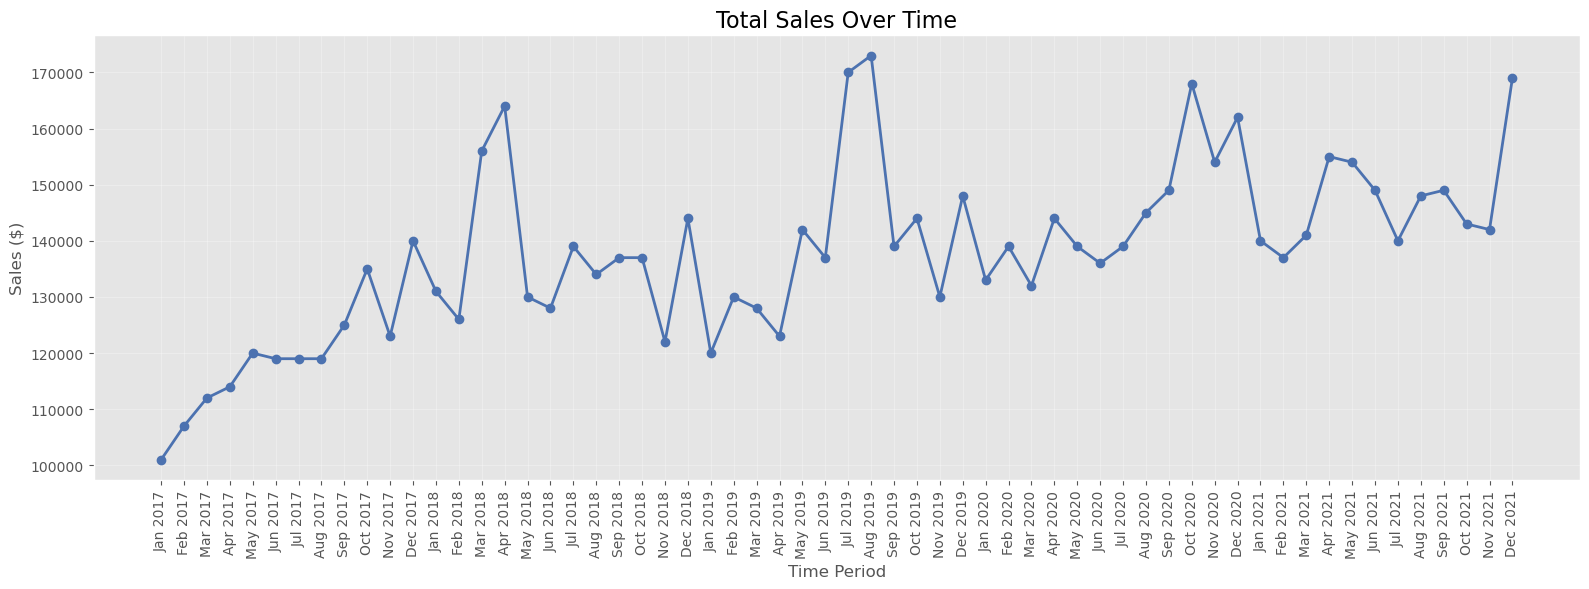

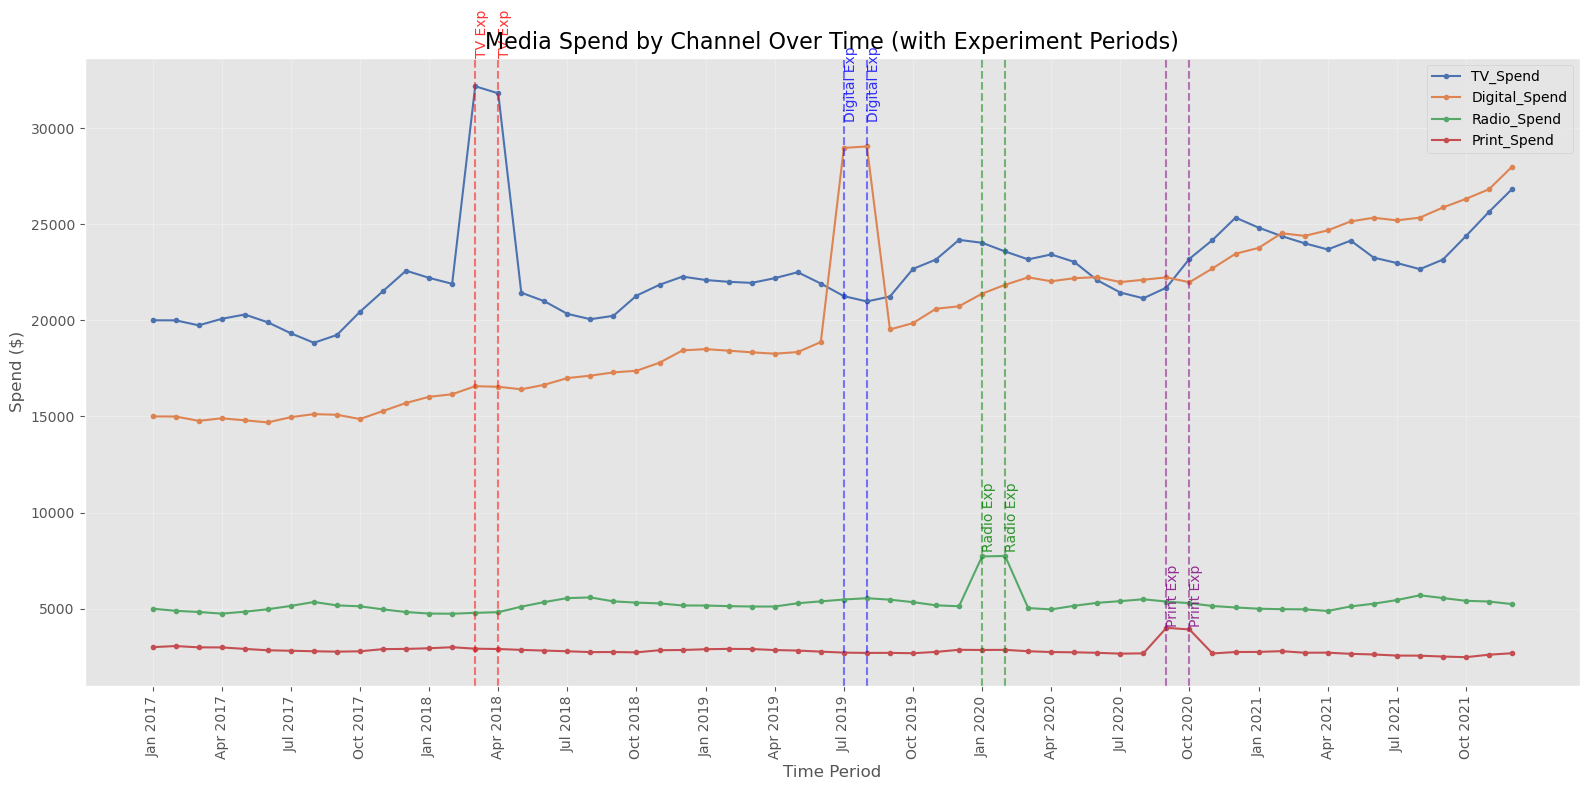

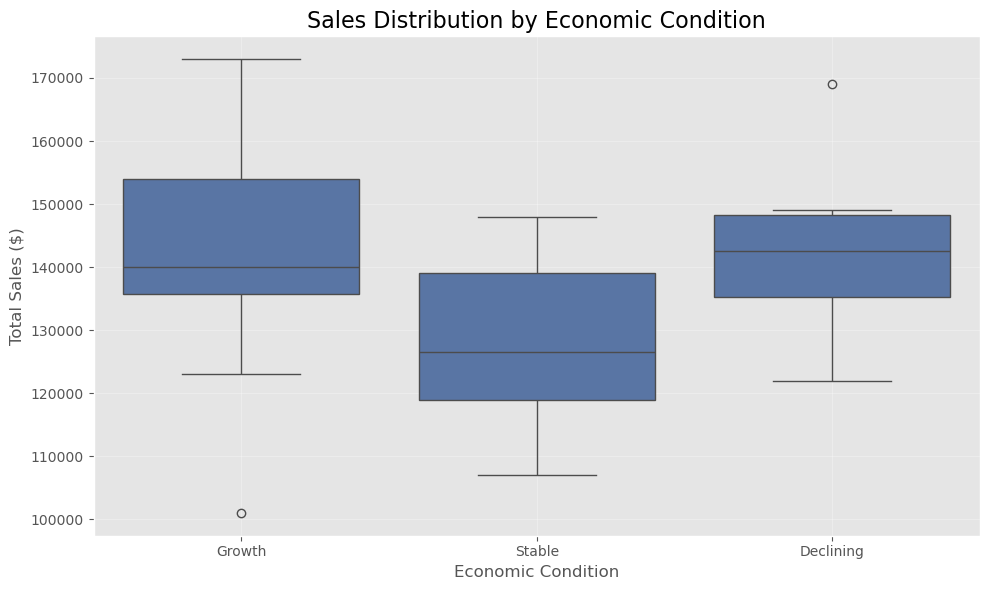

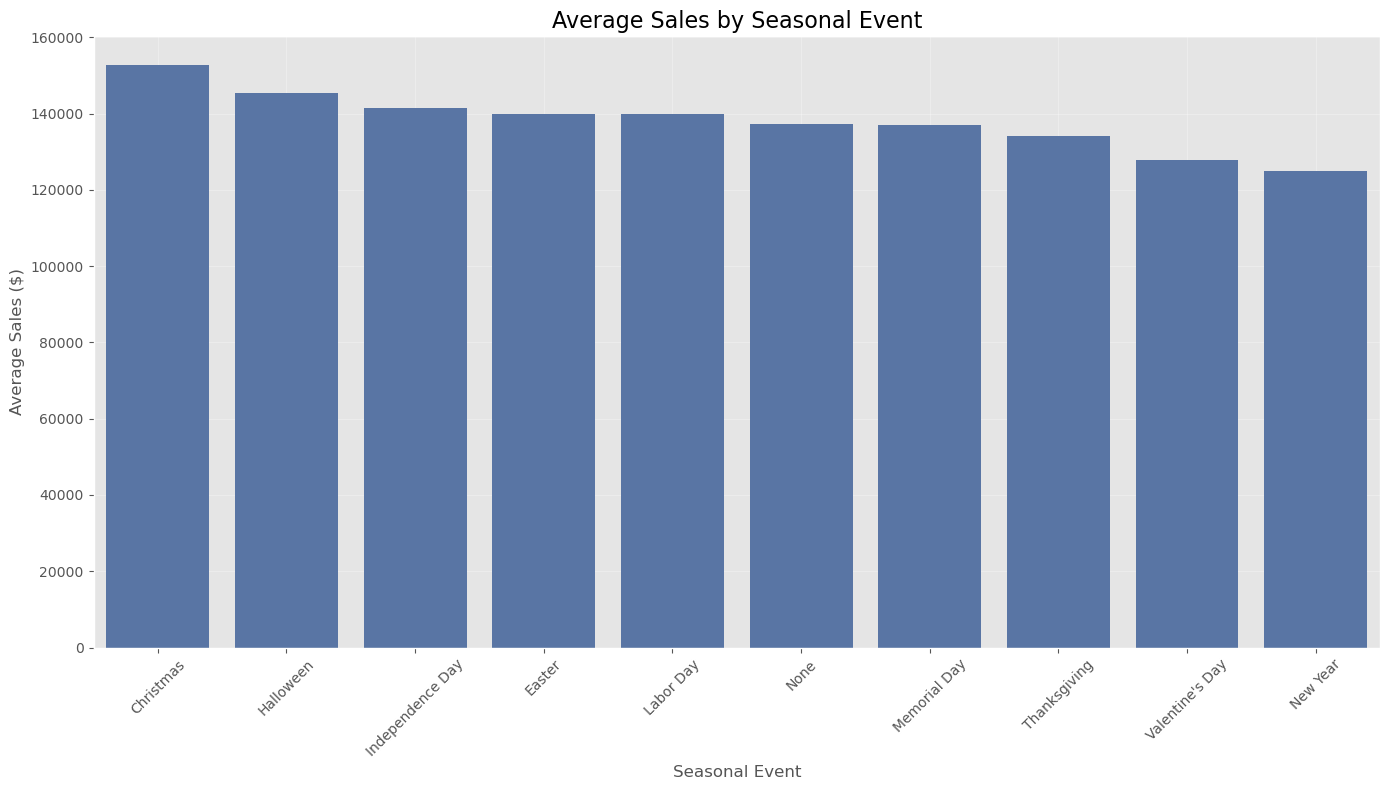

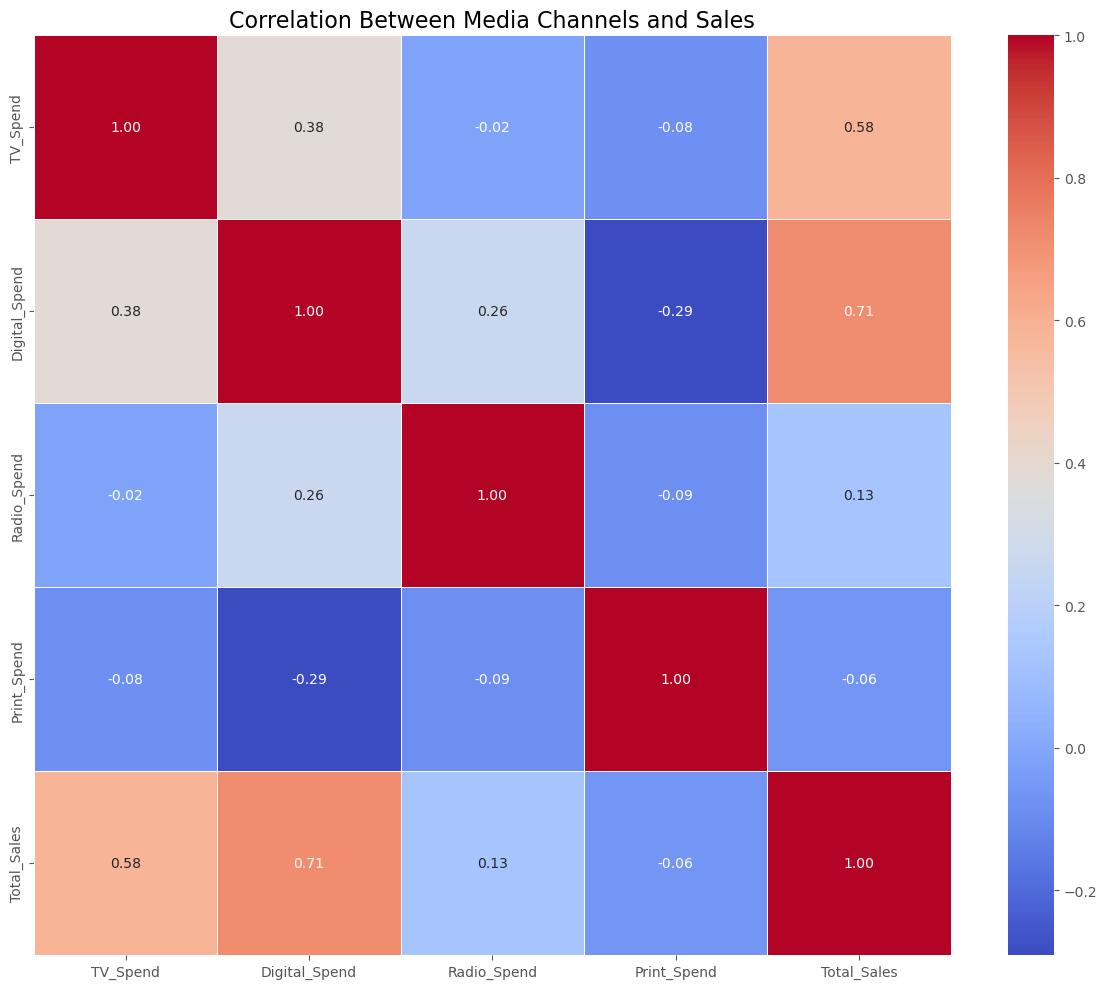

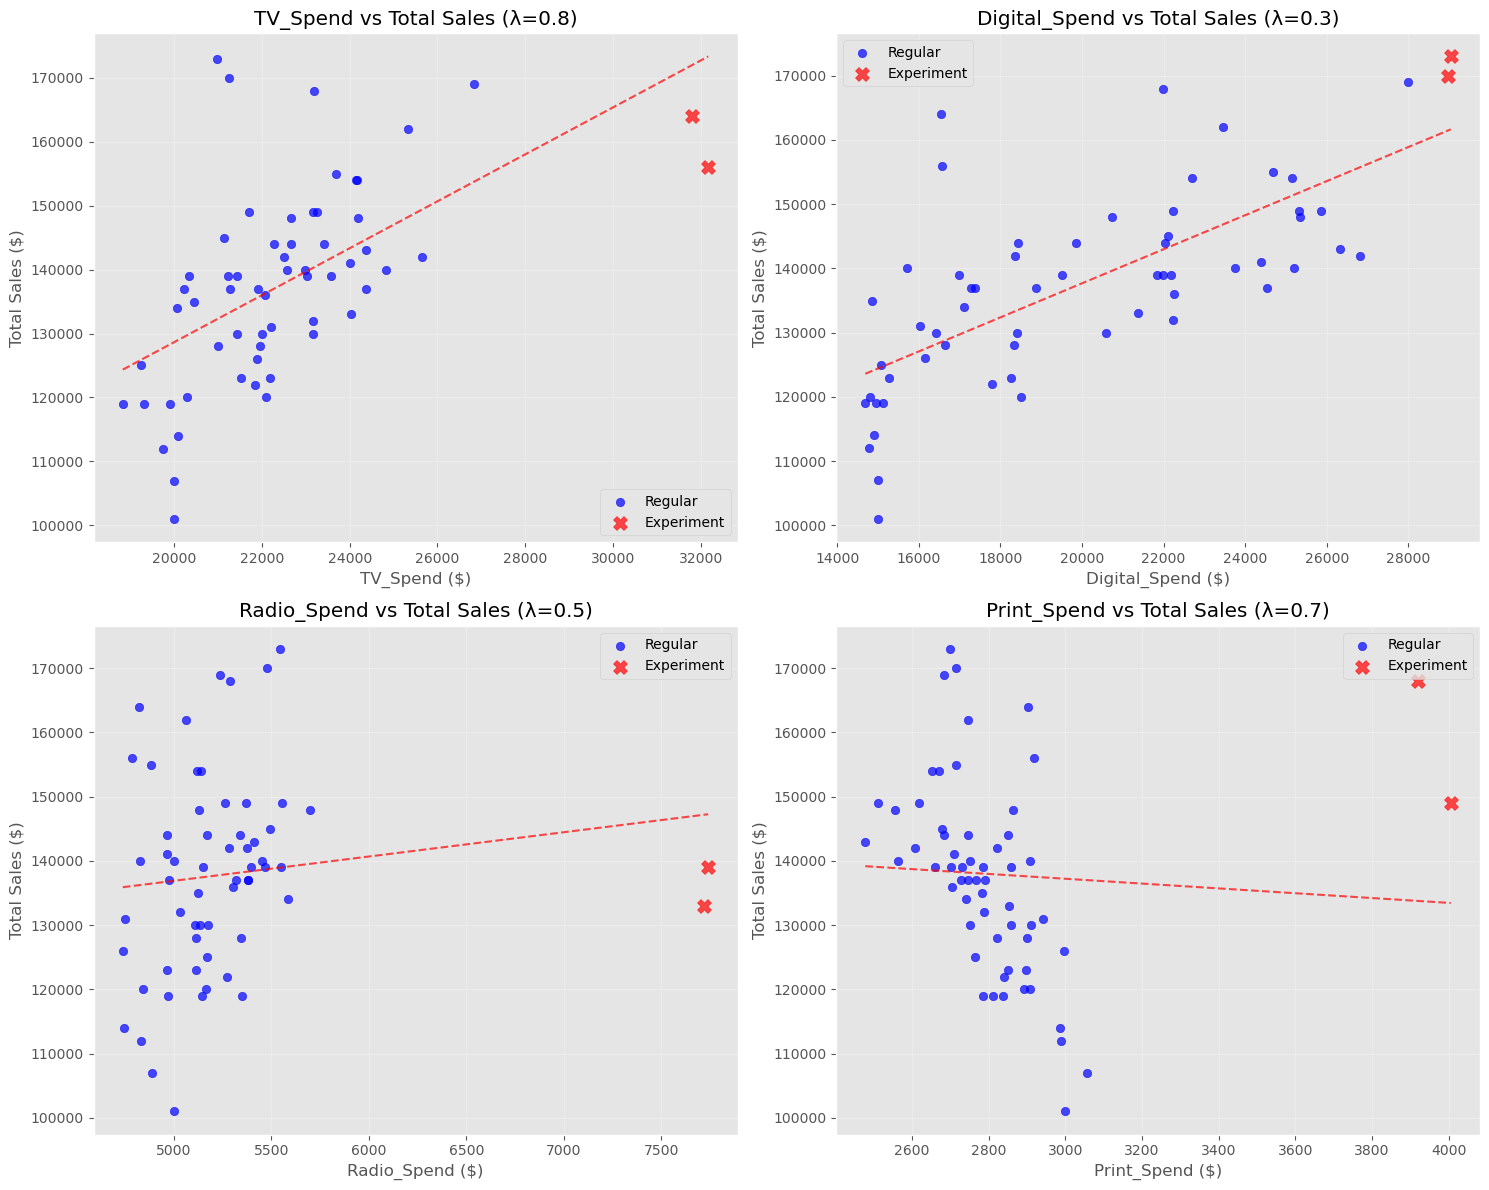

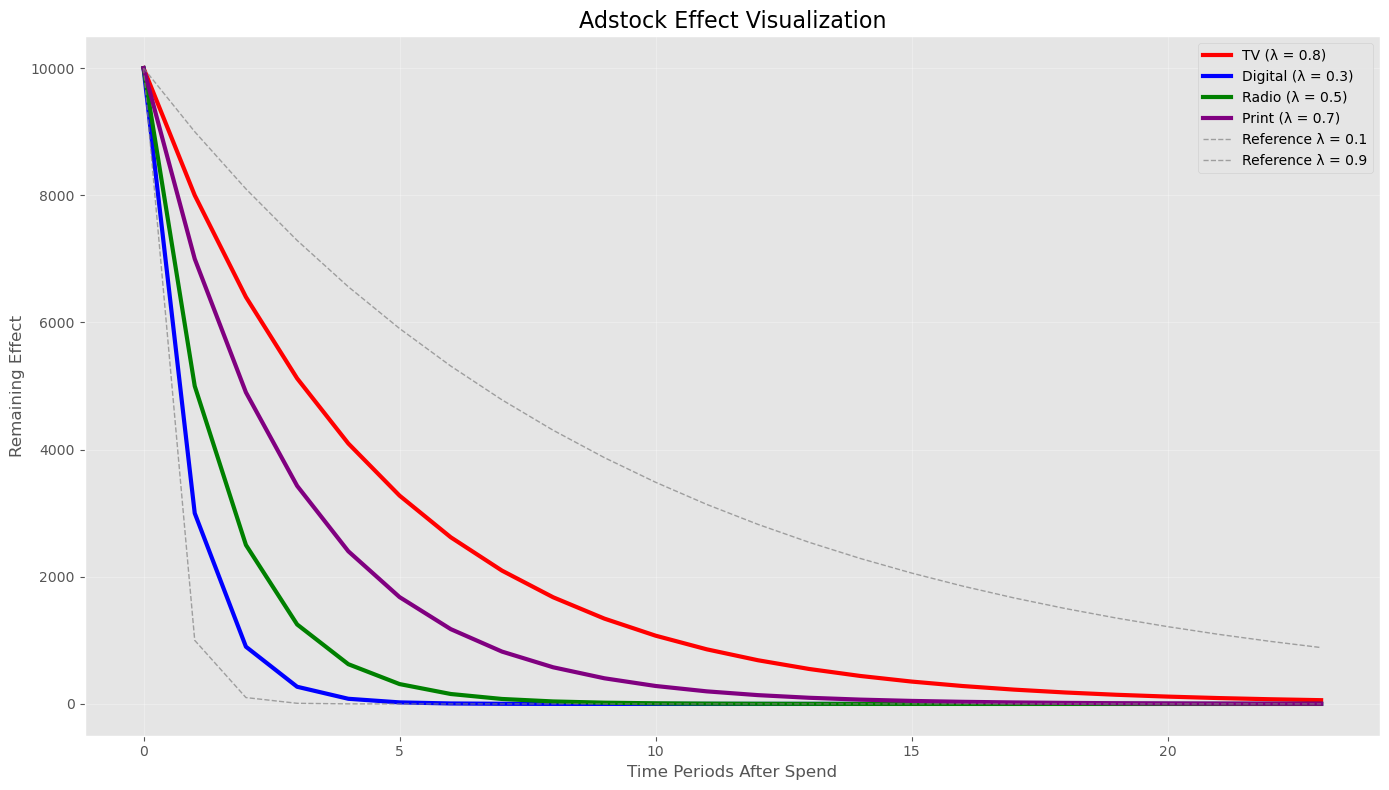

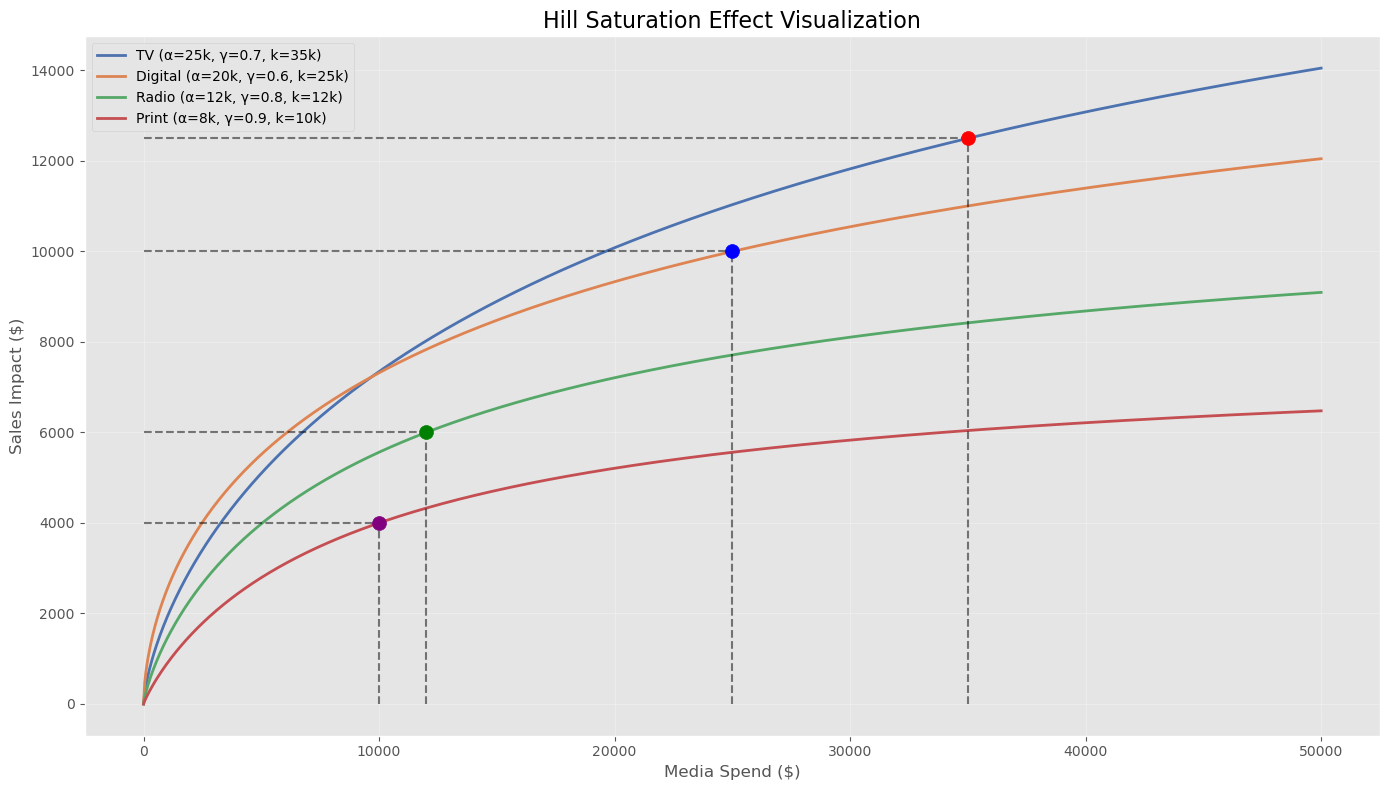

In [129]:
check_data(data_file)

# Testing the data generating process: is parameter recovery possible?

Loading data from MMM_data.csv...

Recovering model parameters...
Step 1: Removing trend and seasonality...
Step 2: Removing economic effects...
Step 3: Removing seasonal event effects...
Step 4: Setting up media variables...
Step 5: Performing sequential parameter recovery...
  Processing TV...
    Step 5.1: Optimizing adstock for TV...
    Optimal decay rate for TV: 0.7401
    Step 5.2: Optimizing Hill function for TV...
    Optimal Hill parameters for TV:
      alpha: 25000.00
      gamma: 0.6990
      k: 35000.00
  Processing Digital...
    Step 5.1: Optimizing adstock for Digital...
    Optimal decay rate for Digital: 0.3229
    Step 5.2: Optimizing Hill function for Digital...
    Optimal Hill parameters for Digital:
      alpha: 20000.00
      gamma: 0.7003
      k: 25000.00
  Processing Radio...
    Step 5.1: Optimizing adstock for Radio...
    Optimal decay rate for Radio: 0.5000
    Step 5.2: Optimizing Hill function for Radio...
    Optimal Hill parameters for Radio:
      a

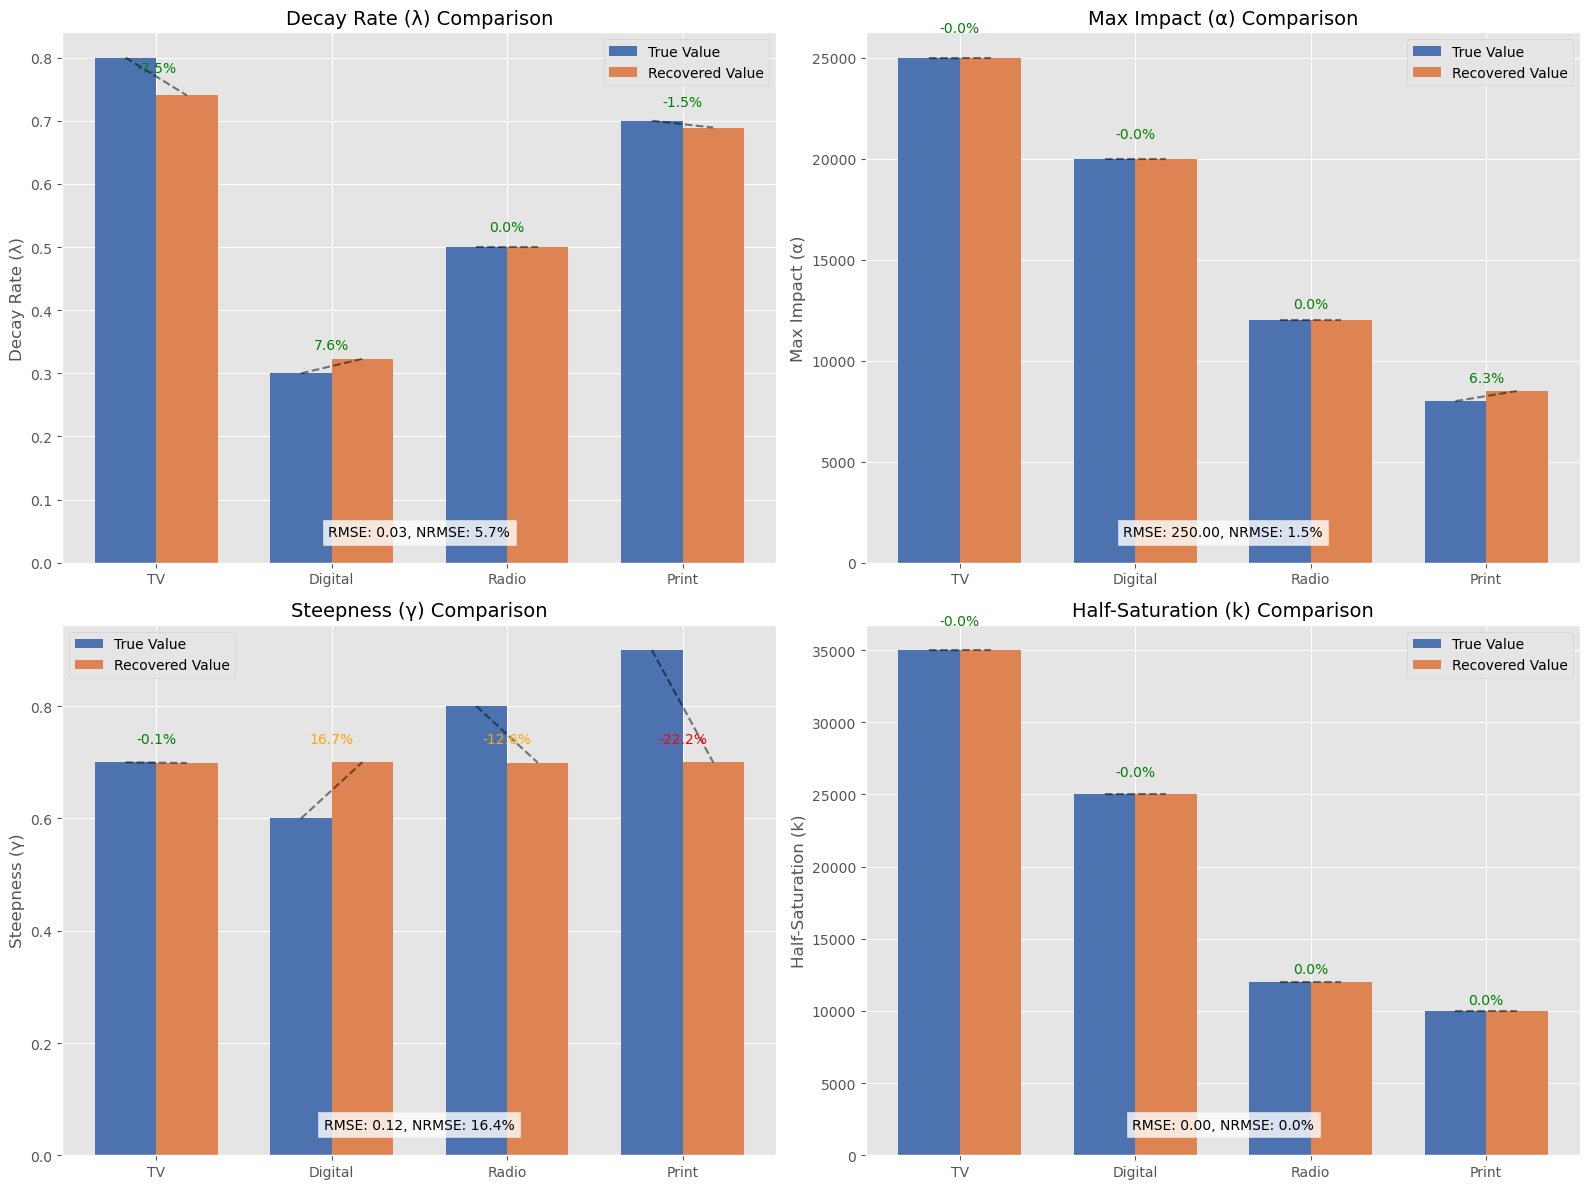


Plotting response curves...


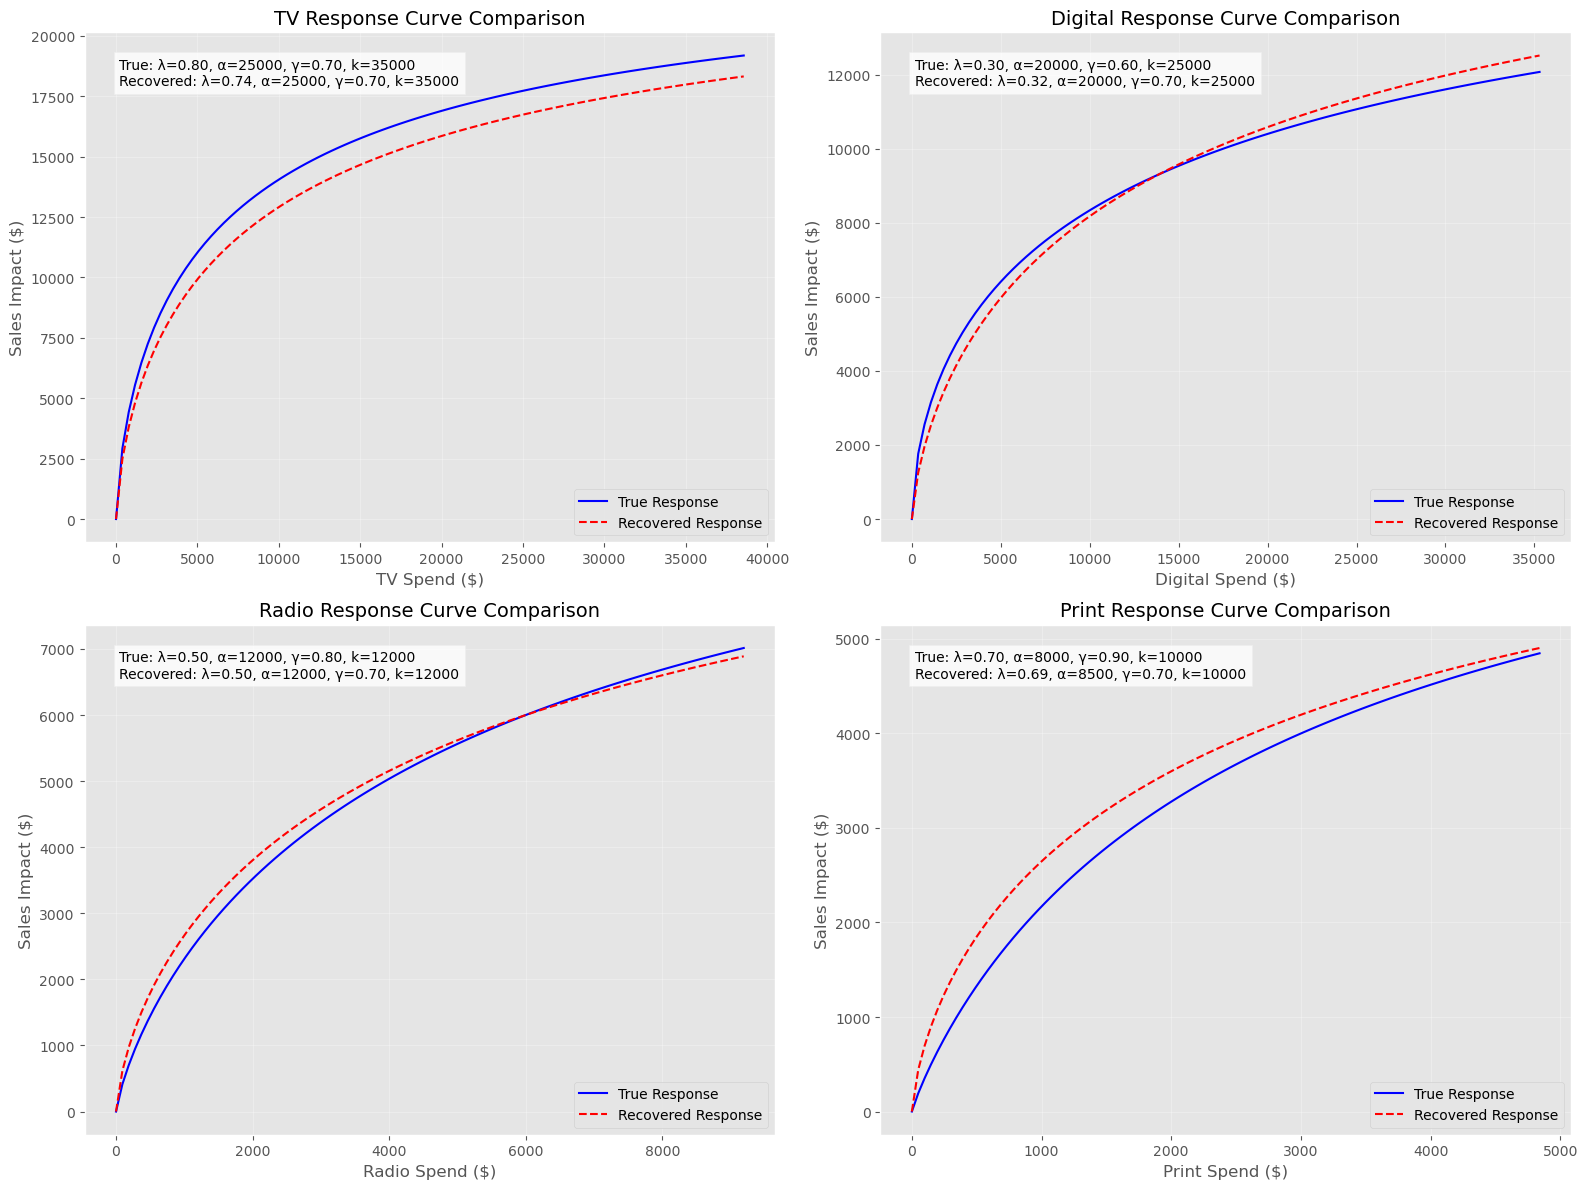


Visualizing model fit...


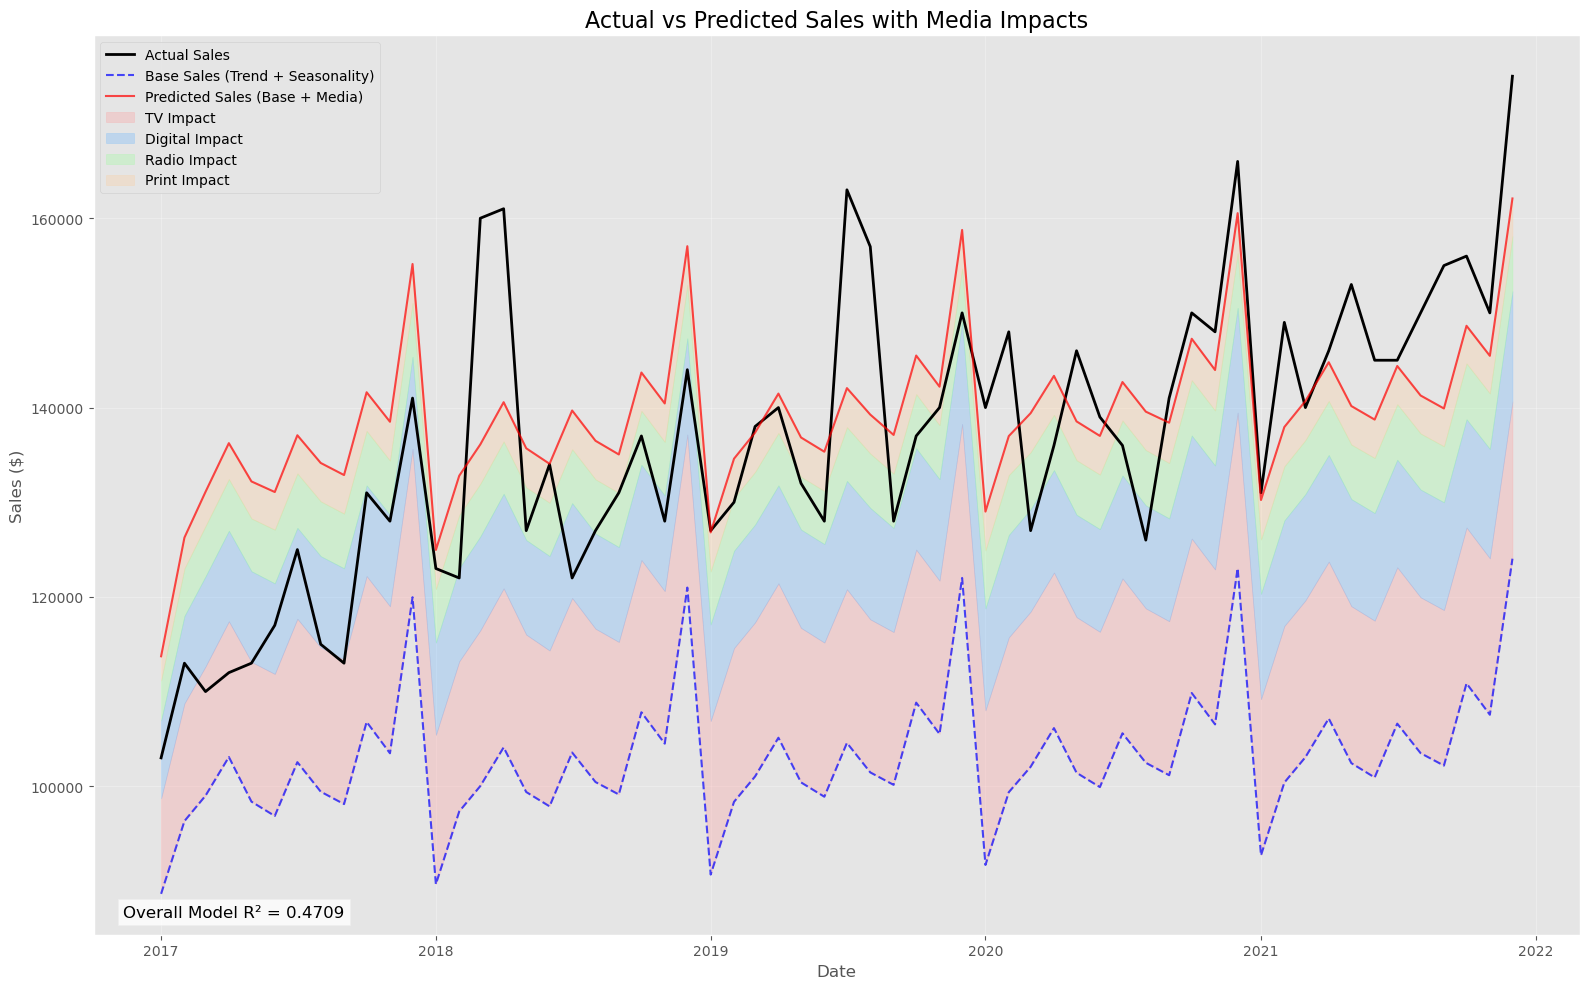


Model fit metrics:
  R-squared: 0.4709
  MAPE: 7.18%
  RMSE: 11518.77


In [143]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.optimize import minimize
from statsmodels.tsa.deterministic import DeterministicProcess
from statsmodels.regression.linear_model import OLS

import numpy as np
import pandas as pd
from statsmodels.tsa.deterministic import DeterministicProcess
from statsmodels.regression.linear_model import OLS
from scipy.optimize import minimize
from sklearn.model_selection import TimeSeriesSplit


def recover_mmm_parameters(data, media_channels=['TV', 'Digital', 'Radio', 'Print'], 
                                   n_splits=3, l2_penalty=0.01):
    """
    Recover adstock and hill function parameters from MMM data using a sequential approach.
    
    Args:
        data (pandas.DataFrame): Media mix model data with columns for media spend and sales
        media_channels (list): List of media channel names
        n_splits (int): Number of time series splits for cross-validation
        l2_penalty (float): Regularization strength for L2 penalty
    
    Returns:
        dict: Recovered parameters for each channel and model results
    """
    # Step 1: Control for base sales trend and seasonality
    # ----------------------------------------------------------
    print("Step 1: Removing trend and seasonality...")
    
    # Convert Time_Period to datetime for proper indexing
    model_data = data.copy()
    try:
        model_data.index = pd.to_datetime(pd.date_range(start='2017-01-01', periods=len(data), freq='MS'))
    except:
        # Fallback if time periods are not easily convertible
        model_data.index = pd.date_range(start='2017-01-01', periods=len(data), freq='MS')
    
    # Add trend and seasonality terms
    dp = DeterministicProcess(
        index=model_data.index,
        constant=True,
        order=1,  # Linear trend
        seasonal=True,
        period=12  # Monthly data
    )
    X_trend_season = dp.in_sample()
    
    # Regression with trend and seasonality
    model_trend_seas = OLS(model_data['Total_Sales'], X_trend_season).fit()
    
    # Extract residuals (sales after removing trend and seasonality)
    sales_detrended = model_trend_seas.resid
    
    # Step 2: Control for economic conditions
    # ----------------------------------------------------------
    print("Step 2: Removing economic effects...")
    
    # One-hot encode economic conditions
    econ_dummies = pd.get_dummies(model_data['Economic_Condition'], prefix='Econ', drop_first=True)
    
    # Handle empty dataframe if all values are the same
    if econ_dummies.empty:
        sales_no_econ = sales_detrended
    else:
        econ_model = OLS(sales_detrended, econ_dummies).fit()
        sales_no_econ = econ_model.resid
    
    # Step 3: Control for seasonal events
    # ----------------------------------------------------------
    print("Step 3: Removing seasonal event effects...")
    
    # One-hot encode seasonal events
    event_dummies = pd.get_dummies(model_data['Seasonal_Event'], prefix='Event', drop_first=True)
    
    # Handle empty dataframe if all values are the same
    if event_dummies.empty:
        sales_residuals = sales_no_econ
    else:
        event_model = OLS(sales_no_econ, event_dummies).fit()
        sales_residuals = event_model.resid
    
    # Setup time series cross-validation
    tscv = TimeSeriesSplit(n_splits=n_splits)
    
    # Final residuals represent sales variation attributable to media spend
    print("Step 4: Setting up media variables...")
    
    # Define more appropriate channel-specific parameter bounds
    param_bounds = {
        'TV': {
            'decay_rate': (0.6, 0.9),    # TV typically has higher decay
            'alpha': (15000, 35000),    # Higher impact
            'gamma': (0.5, 0.9),        # Moderate to high diminishing returns
            'k': (25000, 45000)         # Higher saturation point
        },
        'Digital': {
            'decay_rate': (0.2, 0.5),   # Digital typically has lower decay
            'alpha': (10000, 30000),    # Moderate impact
            'gamma': (0.4, 0.8),        # Moderate diminishing returns
            'k': (15000, 35000)         # Moderate saturation point
        },
        'Radio': {
            'decay_rate': (0.3, 0.7),   # Radio has moderate decay
            'alpha': (8000, 16000),     # Lower impact
            'gamma': (0.6, 0.9),        # Moderate to high diminishing returns
            'k': (8000, 16000)          # Lower saturation point
        },
        'Print': {
            'decay_rate': (0.5, 0.8),   # Print has moderate to high decay
            'alpha': (5000, 12000),     # Lower impact
            'gamma': (0.7, 0.95),       # High diminishing returns
            'k': (7000, 13000)          # Lower saturation point
        }
    }

    # Step 5: Sequential parameter recovery with cross-validation
    # ----------------------------------------------------------
    print("Step 5: Performing sequential parameter recovery...")
    
    recovered_params = {}
    channel_adstocks = {}
    channel_impacts = {}
    
    for channel in media_channels:
        print(f"  Processing {channel}...")
        channel_spend = model_data[f'{channel}_Spend'].values
        
        # PART 1: Optimize adstock parameters first
        # ----------------------------------------------------------
        print(f"    Step 5.1: Optimizing adstock for {channel}...")
        
        # Define objective function for adstock only (with L2 regularization)
        def adstock_objective(params, train_indices, val_indices=None):
            decay_rate = params[0]
            
            # Apply adstock transformation
            adstocked = np.zeros_like(channel_spend)
            adstocked[0] = channel_spend[0]
            for t in range(1, len(channel_spend)):
                adstocked[t] = channel_spend[t] + decay_rate * adstocked[t-1]
            
            # If validation indices provided, use them, otherwise use training indices
            eval_indices = val_indices if val_indices is not None else train_indices
            
            # Calculate correlation between adstocked values and sales residuals
            correlation = np.corrcoef(adstocked[eval_indices], 
                                     sales_residuals[eval_indices])[0, 1]
            r_squared = correlation ** 2
            
            # Add L2 regularization penalty to prevent extreme values
            l2_reg_term = l2_penalty * (decay_rate - 0.5)**2  # Penalize deviation from 0.5
            
            # Return negative R² plus regularization (to minimize)
            return -r_squared + l2_reg_term
        
        # Cross-validation for adstock
        cv_adstock_scores = []
        cv_adstock_params = []
        
        for train_idx, val_idx in tscv.split(sales_residuals):
            # Set initial guess and bounds for this channel
            bounds = [(param_bounds[channel]['decay_rate'])]
            initial_guess = [np.mean(bounds[0])]  # Start in the middle of bounds
            
            # Run optimization on training data
            result = minimize(
                lambda p: adstock_objective(p, train_idx, val_idx),
                initial_guess,
                bounds=bounds,
                method='L-BFGS-B'
            )
            
            cv_adstock_params.append(result.x[0])
            cv_adstock_scores.append(-result.fun)  # Convert back to positive R²
        
        # Use the median of cross-validated parameters for robustness
        optimal_decay = np.median(cv_adstock_params)
        print(f"    Optimal decay rate for {channel}: {optimal_decay:.4f}")
        
        # Calculate adstocked values with optimal decay
        adstocked = np.zeros_like(channel_spend)
        adstocked[0] = channel_spend[0]
        for t in range(1, len(channel_spend)):
            adstocked[t] = channel_spend[t] + optimal_decay * adstocked[t-1]
        
        # Store adstocked values for this channel
        channel_adstocks[channel] = adstocked
        
        # PART 2: Now optimize Hill function parameters with fixed adstock
        # ----------------------------------------------------------------
        print(f"    Step 5.2: Optimizing Hill function for {channel}...")
        
        def hill_objective(params, train_indices, val_indices=None):
            alpha, gamma, k = params
            
            # Use pre-calculated adstocked values
            adstocked_values = channel_adstocks[channel]
            
            # Apply hill transformation
            numerator = adstocked_values ** gamma
            denominator = adstocked_values ** gamma + k ** gamma
            impact = alpha * (numerator / denominator)
            
            # If validation indices provided, use them, otherwise use training indices
            eval_indices = val_indices if val_indices is not None else train_indices
            
            # Calculate R²
            correlation = np.corrcoef(impact[eval_indices], 
                                     sales_residuals[eval_indices])[0, 1]
            r_squared = correlation ** 2
            
            # Add L2 regularization for hill parameters
            l2_reg_term = (
                l2_penalty * ((alpha - 20000)/10000)**2 +  # Penalize deviation from 20,000
                l2_penalty * ((gamma - 0.7)/0.3)**2 +      # Penalize deviation from 0.7
                l2_penalty * ((k - 20000)/10000)**2        # Penalize deviation from 20,000
            )
            
            # Return negative R² plus regularization (to minimize)
            return -r_squared + l2_reg_term
        
        # Cross-validation for Hill function
        cv_hill_scores = []
        cv_hill_params = []
        
        for train_idx, val_idx in tscv.split(sales_residuals):
            # Set bounds for Hill parameters
            bounds = [
                param_bounds[channel]['alpha'],
                param_bounds[channel]['gamma'],
                param_bounds[channel]['k']
            ]
            
            # Start with midpoint of bounds
            initial_guess = [
                np.mean(bounds[0]),
                np.mean(bounds[1]),
                np.mean(bounds[2])
            ]
            
            # Run optimization
            result = minimize(
                lambda p: hill_objective(p, train_idx, val_idx),
                initial_guess,
                bounds=bounds,
                method='L-BFGS-B'
            )
            
            cv_hill_params.append(result.x)
            cv_hill_scores.append(-result.fun)  # Convert back to positive R²
        
        # Use the median of cross-validated parameters for robustness
        optimal_alpha = np.median([p[0] for p in cv_hill_params])
        optimal_gamma = np.median([p[1] for p in cv_hill_params])
        optimal_k = np.median([p[2] for p in cv_hill_params])
        
        print(f"    Optimal Hill parameters for {channel}:")
        print(f"      alpha: {optimal_alpha:.2f}")
        print(f"      gamma: {optimal_gamma:.4f}")
        print(f"      k: {optimal_k:.2f}")
        
        # Store optimized parameters
        recovered_params[channel] = {
            'decay_rate': optimal_decay,
            'alpha': optimal_alpha,
            'gamma': optimal_gamma,
            'k': optimal_k
        }
        
        # Calculate final impact with optimal parameters
        adstocked = channel_adstocks[channel]
        numerator = adstocked ** optimal_gamma
        denominator = adstocked ** optimal_gamma + optimal_k ** optimal_gamma
        impact = optimal_alpha * (numerator / denominator)
        
        # Store channel impacts
        channel_impacts[channel] = impact
    
    # Step 6: Calculate total media impact and evaluate model
    # ----------------------------------------------------------
    print("Step 6: Evaluating final model fit...")
    
    # Compute total media impact
    total_media_impact = np.zeros_like(sales_residuals)
    for channel in media_channels:
        total_media_impact += channel_impacts[channel]
    
    # Calculate overall R²
    correlation = np.corrcoef(total_media_impact, sales_residuals)[0, 1]
    r_squared = correlation ** 2
    print(f"  Overall model R²: {r_squared:.4f}")
    
    # Store the final model and data for plotting
    model_results = {
        'params': recovered_params,
        'fitted_impacts': total_media_impact,
        'sales_residuals': sales_residuals,
        'original_sales': model_data['Total_Sales'].values,
        'r_squared': r_squared,
        'channel_impacts': channel_impacts,
        'channel_adstocks': channel_adstocks
    }
    
    return model_results

def compare_parameters(data, model_results, media_channels=['TV', 'Digital', 'Radio', 'Print']):
    """
    Compare true vs recovered parameters.
    
    Args:
        data (pandas.DataFrame): Original media mix model data with true parameters
        model_results (dict): Results from recover_mmm_parameters
        media_channels (list): List of media channel names
    
    Returns:
        pandas.DataFrame: Comparison of true vs recovered parameters
    """
    # Initialize comparison dataframe
    comparison = []
    
    # Get true and recovered parameters for each channel
    for channel in media_channels:
        # True parameters
        true_decay = data[f'{channel}_Decay'].iloc[0]
        true_alpha = data[f'{channel}_alpha'].iloc[0]
        true_gamma = data[f'{channel}_gamma'].iloc[0]
        true_k = data[f'{channel}_k'].iloc[0]
        
        # Recovered parameters
        recovered = model_results['params'][channel]
        recovered_decay = recovered['decay_rate']
        recovered_alpha = recovered['alpha']
        recovered_gamma = recovered['gamma']
        recovered_k = recovered['k']
        
        # Percent difference
        decay_diff = (recovered_decay - true_decay) / true_decay * 100
        alpha_diff = (recovered_alpha - true_alpha) / true_alpha * 100
        gamma_diff = (recovered_gamma - true_gamma) / true_gamma * 100
        k_diff = (recovered_k - true_k) / true_k * 100
        
        # Add to comparison
        comparison.append({
            'Channel': channel,
            'Parameter': 'Decay Rate (λ)',
            'True Value': true_decay,
            'Recovered Value': recovered_decay,
            'Difference (%)': decay_diff
        })
        
        comparison.append({
            'Channel': channel,
            'Parameter': 'Max Impact (α)',
            'True Value': true_alpha,
            'Recovered Value': recovered_alpha,
            'Difference (%)': alpha_diff
        })
        
        comparison.append({
            'Channel': channel,
            'Parameter': 'Steepness (γ)',
            'True Value': true_gamma,
            'Recovered Value': recovered_gamma,
            'Difference (%)': gamma_diff
        })
        
        comparison.append({
            'Channel': channel,
            'Parameter': 'Half-Saturation (k)',
            'True Value': true_k,
            'Recovered Value': recovered_k,
            'Difference (%)': k_diff
        })
    
    # Convert to dataframe
    comparison_df = pd.DataFrame(comparison)
    
    # Add a summary row with RMSE
    param_types = ['Decay Rate (λ)', 'Max Impact (α)', 'Steepness (γ)', 'Half-Saturation (k)']
    for param in param_types:
        param_df = comparison_df[comparison_df['Parameter'] == param]
        rmse = np.sqrt(np.mean((param_df['True Value'] - param_df['Recovered Value'])**2))
        normalized_rmse = rmse / param_df['True Value'].mean() * 100  # as percentage of mean value
        
        summary_row = pd.DataFrame([{
            'Channel': 'ALL',
            'Parameter': param,
            'True Value': None,
            'Recovered Value': None,
            'Difference (%)': normalized_rmse,
            'RMSE': rmse,
            'NRMSE (%)': normalized_rmse
        }])
        
        comparison_df = pd.concat([comparison_df, summary_row], ignore_index=True)
    
    return comparison_df

def plot_parameter_comparison(comparison_df, media_channels=['TV', 'Digital', 'Radio', 'Print']):
    """
    Plot comparison of true vs recovered parameters.
    
    Args:
        comparison_df (pandas.DataFrame): Output from compare_parameters
        media_channels (list): List of media channel names
    """
    # Set up plot style
    plt.style.use('ggplot')
    sns.set_palette("deep")
    
    # Create a figure with subplots for each parameter type
    param_types = ['Decay Rate (λ)', 'Max Impact (α)', 'Steepness (γ)', 'Half-Saturation (k)']
    
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    axes = axes.flatten()
    
    for i, param_type in enumerate(param_types):
        # Get data for this parameter
        param_df = comparison_df[comparison_df['Parameter'] == param_type]
        param_df = param_df[param_df['Channel'] != 'ALL']  # Exclude summary
        
        # Bar positions
        x = np.arange(len(media_channels))
        width = 0.35
        
        # Create bars
        axes[i].bar(x - width/2, param_df['True Value'], width, label='True Value')
        axes[i].bar(x + width/2, param_df['Recovered Value'], width, label='Recovered Value')
        
        # Add percentage difference as text
        for j, channel in enumerate(media_channels):
            channel_diff = param_df[param_df['Channel'] == channel]['Difference (%)'].values[0]
            color = 'green' if abs(channel_diff) < 10 else 'orange' if abs(channel_diff) < 20 else 'red'
            axes[i].text(j, param_df[param_df['Channel'] == channel]['Recovered Value'].values[0] * 1.05, 
                     f"{channel_diff:.1f}%", ha='center', color=color)
        
        # Add RMSE information
        rmse_row = comparison_df[(comparison_df['Parameter'] == param_type) & (comparison_df['Channel'] == 'ALL')]
        if not rmse_row.empty:
            rmse = rmse_row['RMSE'].values[0]
            nrmse = rmse_row['NRMSE (%)'].values[0]
            axes[i].text(0.5, 0.05, f"RMSE: {rmse:.2f}, NRMSE: {nrmse:.1f}%", 
                     transform=axes[i].transAxes, ha='center', fontsize=10, 
                     bbox=dict(facecolor='white', alpha=0.8))
        
        # Set labels and title
        axes[i].set_ylabel(param_type)
        axes[i].set_title(f"{param_type} Comparison", fontsize=14)
        axes[i].set_xticks(x)
        axes[i].set_xticklabels(media_channels)
        axes[i].legend()
        
        # Draw connecting lines between true and recovered values
        for j in range(len(media_channels)):
            true_val = param_df[param_df['Channel'] == media_channels[j]]['True Value'].values[0]
            recovered_val = param_df[param_df['Channel'] == media_channels[j]]['Recovered Value'].values[0]
            axes[i].plot([j - width/2, j + width/2], [true_val, recovered_val], 'k--', alpha=0.5)
    
    plt.tight_layout()
    plt.show()

def plot_response_curves(data, model_results, media_channels=['TV', 'Digital', 'Radio', 'Print']):
    """
    Plot true vs recovered response curves.
    
    Args:
        data (pandas.DataFrame): Original media mix model data with true parameters
        model_results (dict): Results from recover_mmm_parameters
        media_channels (list): List of media channel names
    """
    # Set up plot style
    plt.style.use('ggplot')
    sns.set_palette("deep")
    
    # Create a figure with subplots for each channel
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    axes = axes.flatten()
    
    for i, channel in enumerate(media_channels):
        # Get true parameters
        true_decay = data[f'{channel}_Decay'].iloc[0]
        true_alpha = data[f'{channel}_alpha'].iloc[0]
        true_gamma = data[f'{channel}_gamma'].iloc[0]
        true_k = data[f'{channel}_k'].iloc[0]
        
        # Get recovered parameters
        recovered = model_results['params'][channel]
        recovered_decay = recovered['decay_rate']
        recovered_alpha = recovered['alpha']
        recovered_gamma = recovered['gamma']
        recovered_k = recovered['k']
        
        # Get max spend for this channel
        max_spend = data[f'{channel}_Spend'].max() * 1.2
        spend_values = np.linspace(0, max_spend, 100)
        
        # Calculate equilibrium adstock for true parameters
        true_eq_adstock = spend_values / (1 - true_decay)
        true_numerator = true_eq_adstock ** true_gamma
        true_denominator = true_eq_adstock ** true_gamma + true_k ** true_gamma
        true_response = true_alpha * (true_numerator / true_denominator)
        
        # Calculate equilibrium adstock for recovered parameters
        recovered_eq_adstock = spend_values / (1 - recovered_decay)
        recovered_numerator = recovered_eq_adstock ** recovered_gamma
        recovered_denominator = recovered_eq_adstock ** recovered_gamma + recovered_k ** recovered_gamma
        recovered_response = recovered_alpha * (recovered_numerator / recovered_denominator)
        
        # Plot response curves
        axes[i].plot(spend_values, true_response, 'b-', label='True Response')
        axes[i].plot(spend_values, recovered_response, 'r--', label='Recovered Response')
        
        # Add parameter information
        param_text = (
            f"True: λ={true_decay:.2f}, α={true_alpha:.0f}, γ={true_gamma:.2f}, k={true_k:.0f}\n"
            f"Recovered: λ={recovered_decay:.2f}, α={recovered_alpha:.0f}, γ={recovered_gamma:.2f}, k={recovered_k:.0f}"
        )
        axes[i].text(0.05, 0.95, param_text, transform=axes[i].transAxes, verticalalignment='top',
                 bbox=dict(facecolor='white', alpha=0.8), fontsize=10)
        
        # Set labels and title
        axes[i].set_xlabel(f'{channel} Spend ($)')
        axes[i].set_ylabel('Sales Impact ($)')
        axes[i].set_title(f'{channel} Response Curve Comparison', fontsize=14)
        axes[i].grid(True, alpha=0.3)
        axes[i].legend()
    
    plt.tight_layout()
    plt.show()

def visualize_fitted_model(data, model_results):
    """
    Visualize fitted model vs actual sales.
    
    Args:
        data (pandas.DataFrame): Original media mix model data
        model_results (dict): Results from recover_mmm_parameters
    """
    # Create a copy of the data with a proper datetime index for plotting
    plot_data = data.copy()
    date_index = pd.date_range(start=data['Time_Period'].iloc[0], periods=len(data), freq='MS')
    
    # Calculate adstocked values for each channel
    adstocked_values = {}
    impacts = {}
    
    for channel in ['TV', 'Digital', 'Radio', 'Print']:
        # Get recovered parameters
        channel_params = model_results['params'][channel]
        decay_rate = channel_params['decay_rate']
        alpha = channel_params['alpha']
        gamma = channel_params['gamma']
        k = channel_params['k']
        
        # Calculate adstocked values
        spend = data[f'{channel}_Spend'].values
        adstocked = np.zeros_like(spend)
        adstocked[0] = spend[0]
        for t in range(1, len(spend)):
            adstocked[t] = spend[t] + decay_rate * adstocked[t-1]
        
        adstocked_values[channel] = adstocked
        
        # Calculate impact
        numerator = adstocked ** gamma
        denominator = numerator + k ** gamma
        impact = alpha * (numerator / denominator)
        impacts[channel] = impact
    
    # Calculate total media impact
    total_media_impact = np.sum([impacts[ch] for ch in impacts], axis=0)
    
    # Create a simplified base estimate using average sales minus media impact
    base_estimate = data['Total_Sales'].mean() - np.mean(total_media_impact)
    
    # Add seasonal pattern (estimated from the months in the data)
    seasonal_pattern = np.zeros(12)
    months = [date.month for date in date_index]
    
    for month in range(1, 13):  # Months are 1-based
        # Find indices of this month in the data
        month_indices = [i for i, m in enumerate(months) if m == month]
        if month_indices:
            # Calculate average sales for this month
            month_sales = np.mean([data['Total_Sales'].iloc[i] for i in month_indices])
            # Calculate seasonal adjustment
            seasonal_pattern[month-1] = month_sales - data['Total_Sales'].mean()
    
    # Apply seasonal pattern to base estimate
    base_prediction = np.array([base_estimate + seasonal_pattern[month-1] for month in months])
    
    # Add trend (simple linear)
    trend = np.linspace(0, 5000, len(data))  # Simple linear trend
    base_prediction += trend
    
    # Plot results
    plt.figure(figsize=(16, 10))
    
    # Plot actual sales
    plt.plot(date_index, data['Total_Sales'], 'k-', label='Actual Sales', linewidth=2)
    
    # Plot base prediction
    plt.plot(date_index, base_prediction, 'b--', label='Base Sales (Trend + Seasonality)', alpha=0.7)
    
    # Plot base + media
    plt.plot(date_index, base_prediction + total_media_impact, 'r-', 
             label='Predicted Sales (Base + Media)', alpha=0.7)
    
    # Plot individual channel impacts as stacked areas
    bottom = base_prediction
    colors = ['#ff9999', '#66b3ff', '#99ff99', '#ffcc99']
    
    for i, (channel, impact) in enumerate(impacts.items()):
        plt.fill_between(date_index, bottom, bottom + impact, 
                         color=colors[i], alpha=0.3, label=f'{channel} Impact')
        bottom = bottom + impact
    
    # Add legend and labels
    plt.legend(loc='upper left')
    plt.title('Actual vs Predicted Sales with Media Impacts', fontsize=16)
    plt.xlabel('Date', fontsize=12)
    plt.ylabel('Sales ($)', fontsize=12)
    plt.grid(True, alpha=0.3)
    
    # Add R-squared annotation
    r_squared = np.corrcoef(data['Total_Sales'], base_prediction + total_media_impact)[0, 1]**2
    plt.annotate(f'Overall Model R² = {r_squared:.4f}', 
                 xy=(0.02, 0.02), xycoords='axes fraction',
                 bbox=dict(facecolor='white', alpha=0.8), fontsize=12)
    
    plt.tight_layout()
    plt.show()
    
    # Return fit statistics
    return {
        'r_squared': r_squared,
        'mape': np.mean(np.abs((data['Total_Sales'] - (base_prediction + total_media_impact)) / data['Total_Sales'])) * 100,
        'rmse': np.sqrt(np.mean((data['Total_Sales'] - (base_prediction + total_media_impact))**2))
    }

def run_full_analysis(data_file):
    """
    Run a complete MMM analysis pipeline.
    
    Args:
        data_file (str): Path to CSV file with MMM data
    """
    # Load data
    print(f"Loading data from {data_file}...")
    data = pd.read_csv(data_file)
    
    # Recover parameters
    print("\nRecovering model parameters...")
    model_results = recover_mmm_parameters(data)
    
    # Compare parameters
    print("\nComparing true vs recovered parameters...")
    comparison_df = compare_parameters(data, model_results)
    
    # Display parameter comparison
    print("\nParameter comparison:")
    print(comparison_df.to_string())
    
    # Plot parameter comparison
    print("\nPlotting parameter comparisons...")
    plot_parameter_comparison(comparison_df)
    
    # Plot response curves
    print("\nPlotting response curves...")
    plot_response_curves(data, model_results)
    
    # Visualize model fit
    print("\nVisualizing model fit...")
    fit_metrics = visualize_fitted_model(data, model_results)
    
    print("\nModel fit metrics:")
    print(f"  R-squared: {fit_metrics['r_squared']:.4f}")
    print(f"  MAPE: {fit_metrics['mape']:.2f}%")
    print(f"  RMSE: {fit_metrics['rmse']:.2f}")
    
    return {
        'model_results': model_results,
        'comparison': comparison_df,
        'fit_metrics': fit_metrics
    }

results=run_full_analysis(data_file)